In [12]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from scipy import stats

def estimate_propensity_score(data, treatment_col, covariates, seed=42):
    """Estima propensity score con logit"""
    vars_needed = [treatment_col] + covariates
    df = data[vars_needed].dropna().copy()
    
    X = df[covariates]
    y = df[treatment_col]
    
    logit_model = LogisticRegression(max_iter=1000, solver='newton-cg', random_state=seed)
    logit_model.fit(X, y)
    df['pscore'] = logit_model.predict_proba(X)[:, 1]
    
    return df


def psmatch2_matching(data, treatment_col, outcome_col, seed=42):
    """Replica psmatch2: matching 1:1 sin reemplazo"""
    np.random.seed(seed)
    
    df = data.copy()
    treated = df[df[treatment_col] == 1].copy().reset_index(drop=True)
    controls = df[df[treatment_col] == 0].copy().reset_index(drop=True)
    
    controls_available = controls.copy()
    matched_controls_indices = []
    
    for idx, treated_row in treated.iterrows():
        if len(controls_available) == 0:
            break
            
        distances = np.abs(controls_available['pscore'].values - treated_row['pscore'])
        min_idx = np.argmin(distances)
        
        matched_controls_indices.append(controls_available.index[min_idx])
        controls_available = controls_available.drop(controls_available.index[min_idx])
    
    matched_controls = controls.loc[matched_controls_indices].copy()
    matched_treated = treated.iloc[:len(matched_controls_indices)].copy()
    
    matched_treated['_weight'] = 1
    matched_controls['_weight'] = 1
    matched_treated['_original_order'] = range(len(matched_treated))
    matched_controls['_original_order'] = range(len(matched_controls))
    
    matched_data = pd.concat([matched_treated, matched_controls], ignore_index=True)
    
    return matched_data


def attnd_matching_true_forward_backward(data, treatment_col, outcome_col, seed=42):
    """
    Replica fielmente el algoritmo attnd:
    1. Ordena TODA la muestra (tratados y controles mezclados) por pscore
    2. Para cada tratado, busca forward y backward en la lista ordenada
    3. Selecciona el control más cercano disponible
    4. Random draw si hay empates forward/backward
    """
    np.random.seed(seed)
    
    df = data.copy()
    
    # CRÍTICO: Ordenar TODA la muestra mezclada por pscore
    df['_original_index'] = df.index
    df = df.sort_values('pscore', kind='stable').reset_index(drop=True)
    
    # Separar tratados y controles pero mantener sus posiciones en el ordenamiento
    treated_positions = df[df[treatment_col] == 1].index.tolist()
    control_positions = df[df[treatment_col] == 0].index.tolist()
    
    matched_pairs = []
    used_controls = set()
    
    # Procesar cada tratado en orden de pscore
    for treated_pos in treated_positions:
        treated_row = df.iloc[treated_pos]
        
        # Controles disponibles (no usados)
        available_control_positions = [p for p in control_positions if p not in used_controls]
        
        if len(available_control_positions) == 0:
            # No hay más controles disponibles
            continue
        
        # Forward search: controles después del tratado en la lista ordenada
        forward_controls = [p for p in available_control_positions if p > treated_pos]
        # Backward search: controles antes del tratado
        backward_controls = [p for p in available_control_positions if p < treated_pos]
        
        best_match_pos = None
        
        if len(forward_controls) > 0 and len(backward_controls) > 0:
            # Hay controles en ambas direcciones
            forward_pos = forward_controls[0]  # El más cercano hacia adelante
            backward_pos = backward_controls[-1]  # El más cercano hacia atrás
            
            forward_dist = abs(df.iloc[forward_pos]['pscore'] - treated_row['pscore'])
            backward_dist = abs(df.iloc[backward_pos]['pscore'] - treated_row['pscore'])
            
            if abs(forward_dist - backward_dist) < 1e-10:  # Empate (tolerancia numérica)
                # Random draw entre forward y backward
                best_match_pos = np.random.choice([forward_pos, backward_pos])
            elif forward_dist < backward_dist:
                best_match_pos = forward_pos
            else:
                best_match_pos = backward_pos
                
        elif len(forward_controls) > 0:
            # Solo hay controles hacia adelante
            best_match_pos = forward_controls[0]
        elif len(backward_controls) > 0:
            # Solo hay controles hacia atrás
            best_match_pos = backward_controls[-1]
        else:
            # No hay controles disponibles
            continue
        
        # Registrar el match
        control_row = df.iloc[best_match_pos]
        
        matched_pairs.append({
            'treated_outcome': treated_row[outcome_col],
            'control_outcome': control_row[outcome_col],
            'treated_pscore': treated_row['pscore'],
            'control_pscore': control_row['pscore'],
            'distance': abs(treated_row['pscore'] - control_row['pscore'])
        })
        
        # Marcar control como usado
        used_controls.add(best_match_pos)
    
    matched_df = pd.DataFrame(matched_pairs)
    return matched_df


def bootstrap_att_attnd_faithful(data_matched_psmatch2, treatment_col, 
                                   outcome_col, n_bootstrap=10, seed=42):
    """Bootstrap fiel al procedimiento de attnd en Stata"""
    np.random.seed(seed)
    
    # ATT en muestra original
    matched_attnd = attnd_matching_true_forward_backward(
        data_matched_psmatch2, treatment_col, outcome_col, seed=seed
    )
    
    att_original = (matched_attnd['treated_outcome'] - 
                    matched_attnd['control_outcome']).mean()
    n_treat = len(matched_attnd)
    n_ctrl = len(matched_attnd)
    
    print(f"\nattnd matching sobre muestra psmatch2:")
    print(f"  Pares matcheados por attnd: {len(matched_attnd)}")
    print(f"  Distancia promedio: {matched_attnd['distance'].mean():.6f}")
    print(f"  Distancia máxima: {matched_attnd['distance'].max():.6f}")
    
    # Bootstrap
    att_bootstrap = []
    
    for b in range(n_bootstrap):
        df_boot = data_matched_psmatch2.sample(
            n=len(data_matched_psmatch2), 
            replace=True, 
            random_state=seed+b
        )
        
        try:
            matched_boot = attnd_matching_true_forward_backward(
                df_boot, treatment_col, outcome_col, seed=seed+b
            )
            
            if len(matched_boot) > 0:
                att_b = (matched_boot['treated_outcome'] - 
                        matched_boot['control_outcome']).mean()
                att_bootstrap.append(att_b)
        except:
            continue
    
    se_boot = np.std(att_bootstrap, ddof=1)
    t_stat = att_original / se_boot if se_boot > 0 else 0
    
    return att_original, se_boot, t_stat, n_treat, n_ctrl, matched_attnd

In [13]:
import pyreadstat as st

PATH = r"C:\Users\HP\OneDrive\Escritorio\David Guzzi\DiTella\MEC\Materias\2025\2025 2T\[MT08-MT13] Microeconometría II\Clases prácticas\PS\PS2-20251111\base_con_orden.dta"

df, meta = st.read_dta(PATH)

treatment = 'mbsmoke'
outcome = 'bweight'
covariates = ['mmarried', 'deadkids', 'nprenatal', 'monthslb', 
                'prenatal', 'fbaby', 'alcohol']

print("\n" + "="*60)
print("PASO 1: Estimación de propensity score (logit)")
print("="*60)

df_with_pscore = estimate_propensity_score(
    data=df,
    treatment_col=treatment,
    covariates=covariates,
    seed=42
)
df_with_pscore[outcome] = df[outcome]

print(f"Observaciones con pscore: {len(df_with_pscore)}")

print("\n" + "="*60)
print("PASO 2: psmatch2 - Matching sin reemplazo")
print("="*60)

matched_psmatch2 = psmatch2_matching(
    data=df_with_pscore,
    treatment_col=treatment,
    outcome_col=outcome,
    seed=42
)

print(f"Observaciones con _weight = 1: {len(matched_psmatch2)}")
print(f"  Tratados: {len(matched_psmatch2[matched_psmatch2[treatment]==1])}")
print(f"  Controles: {len(matched_psmatch2[matched_psmatch2[treatment]==0])}")

print("\n" + "="*60)
print("PASO 3: attnd - Bootstrap sobre muestra filtrada")
print("="*60)
print("ATT estimation with Nearest Neighbor Matching method")
print("(random draw version)")
print("Bootstrapped standard errors")
print("="*60)

att, se, t_stat, n_treat, n_ctrl, matched_df = bootstrap_att_attnd_faithful(
    data_matched_psmatch2=matched_psmatch2,
    treatment_col=treatment,
    outcome_col=outcome,
    n_bootstrap=10,
    seed=42
)

print(f"\n{'n. treat.':>12} {'n. contr.':>12} {'ATT':>12} {'Std. Err.':>12} {'t':>12}")
print("-"*60)
print(f"{n_treat:>12} {n_ctrl:>12} {att:>12.3f} {se:>12.3f} {t_stat:>12.3f}")
print("-"*60)
print("Note: the numbers of treated and controls refer to actual")
print("nearest neighbour matches")
print("\n")

# Diagnóstico adicional
print("="*60)
print("DIAGNÓSTICO")
print("="*60)
print(f"Tratados sin match: {864 - n_treat}")

# Verificar distribución de pscores
treated_psmatch2 = matched_psmatch2[matched_psmatch2[treatment]==1]
control_psmatch2 = matched_psmatch2[matched_psmatch2[treatment]==0]

print(f"\nPropensity scores en muestra psmatch2:")
print(f"  Tratados: min={treated_psmatch2['pscore'].min():.6f}, max={treated_psmatch2['pscore'].max():.6f}")
print(f"  Controles: min={control_psmatch2['pscore'].min():.6f}, max={control_psmatch2['pscore'].max():.6f}")


PASO 1: Estimación de propensity score (logit)
Observaciones con pscore: 4642

PASO 2: psmatch2 - Matching sin reemplazo
Observaciones con _weight = 1: 1728
  Tratados: 864
  Controles: 864

PASO 3: attnd - Bootstrap sobre muestra filtrada
ATT estimation with Nearest Neighbor Matching method
(random draw version)
Bootstrapped standard errors

attnd matching sobre muestra psmatch2:
  Pares matcheados por attnd: 864
  Distancia promedio: 0.010808
  Distancia máxima: 0.654189

   n. treat.    n. contr.          ATT    Std. Err.            t
------------------------------------------------------------
         864          864     -241.848       28.526       -8.478
------------------------------------------------------------
Note: the numbers of treated and controls refer to actual
nearest neighbour matches


DIAGNÓSTICO
Tratados sin match: 0

Propensity scores en muestra psmatch2:
  Tratados: min=0.074387, max=0.834411
  Controles: min=0.074387, max=0.786702


In [11]:
import pyreadstat as st

PATH = r"C:\Users\HP\OneDrive\Escritorio\David Guzzi\DiTella\MEC\Materias\2025\2025 2T\[MT08-MT13] Microeconometría II\Clases prácticas\PS\PS2-20251111\base_con_orden.dta"

df, meta = st.read_dta(PATH)

# Definir variables
treatment = 'mbsmoke'
outcome = 'bweight'
covariates = ['mmarried', 'deadkids', 'nprenatal', 'monthslb', 
                'prenatal', 'fbaby', 'alcohol']

print("\n" + "="*60)
print("PASO 1: Estimación de propensity score (logit)")
print("="*60)

# Estimar propensity score
df_with_pscore = estimate_propensity_score(
    data=df,
    treatment_col=treatment,
    covariates=covariates,
    seed=42
)

# Agregar outcome al dataframe
df_with_pscore[outcome] = df[outcome]

print(f"Observaciones con pscore: {len(df_with_pscore)}")

print("\n" + "="*60)
print("PASO 2: psmatch2 - Matching sin reemplazo")
print("="*60)

# psmatch2 matching
matched_psmatch2 = psmatch2_matching(
    data=df_with_pscore,
    treatment_col=treatment,
    outcome_col=outcome,
    seed=42
)

print(f"Observaciones con _weight = 1: {len(matched_psmatch2)}")
print(f"  Tratados: {len(matched_psmatch2[matched_psmatch2[treatment]==1])}")
print(f"  Controles: {len(matched_psmatch2[matched_psmatch2[treatment]==0])}")

# EQUIVALENTE A: keep if _weight == 1
# (matched_psmatch2 ya contiene solo estas observaciones)

print("\n" + "="*60)
print("PASO 3: attnd - Bootstrap sobre muestra filtrada")
print("="*60)
print("ATT estimation with Nearest Neighbor Matching method")
print("(random draw version)")
print("Bootstrapped standard errors")
print("="*60)

# Bootstrap con attnd
att, se, t_stat, n_treat, n_ctrl = bootstrap_att_attnd_style(
    data_full=df_with_pscore,
    data_matched_psmatch2=matched_psmatch2,
    treatment_col=treatment,
    outcome_col=outcome,
    covariates=covariates,
    n_bootstrap=10,
    seed=42
)

print(f"\n{'n. treat.':>12} {'n. contr.':>12} {'ATT':>12} {'Std. Err.':>12} {'t':>12}")
print("-"*60)
print(f"{n_treat:>12} {n_ctrl:>12} {att:>12.3f} {se:>12.3f} {t_stat:>12.3f}")
print("-"*60)
print("Note: the numbers of treated and controls refer to actual")
print("nearest neighbour matches")
print("\n")


PASO 1: Estimación de propensity score (logit)
Observaciones con pscore: 4642

PASO 2: psmatch2 - Matching sin reemplazo
Observaciones con _weight = 1: 1728
  Tratados: 864
  Controles: 864

PASO 3: attnd - Bootstrap sobre muestra filtrada
ATT estimation with Nearest Neighbor Matching method
(random draw version)
Bootstrapped standard errors

attnd matching sobre muestra psmatch2:
  Pares matcheados por attnd: 864

   n. treat.    n. contr.          ATT    Std. Err.            t
------------------------------------------------------------
         864          864     -241.848       28.621       -8.450
------------------------------------------------------------
Note: the numbers of treated and controls refer to actual
nearest neighbour matches




In [1]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import NearestNeighbors
from scipy import stats

def propensity_score_matching(data, treatment_col, outcome_col, covariates, seed=42):
    """
    Realiza Propensity Score Matching con Nearest Neighbor sin reemplazo
    Retorna solo las observaciones matcheadas
    """
    np.random.seed(seed)
    
    # 1. Eliminar observaciones con valores faltantes
    vars_needed = [treatment_col, outcome_col] + covariates
    df = data[vars_needed].dropna().copy()
    df = df.reset_index(drop=True)
    
    # 2. Estimar modelo logit para propensity score
    X = df[covariates]
    y = df[treatment_col]
    
    logit_model = LogisticRegression(max_iter=1000, solver='newton-cg', random_state=seed)
    logit_model.fit(X, y)
    
    # 3. Predecir propensity scores
    df['pscore'] = logit_model.predict_proba(X)[:, 1]
    
    # 4. Separar tratados y controles
    treated = df[df[treatment_col] == 1].copy().reset_index(drop=True)
    controls = df[df[treatment_col] == 0].copy().reset_index(drop=True)
    
    # 5. Nearest Neighbor Matching (sin reemplazo)
    nn = NearestNeighbors(n_neighbors=1, metric='euclidean')
    nn.fit(controls[['pscore']].values)
    
    distances, indices = nn.kneighbors(treated[['pscore']].values)
    
    # 6. Crear dataset matched (equivalente a keep if _weight == 1)
    matched_controls = controls.iloc[indices.flatten()].copy()
    matched_treated = treated.copy()
    
    # Marcar las observaciones como matcheadas
    matched_treated['_weight'] = 1
    matched_controls['_weight'] = 1
    matched_treated['_id'] = 'treated'
    matched_controls['_id'] = 'control'
    
    # Combinar tratados y controles matcheados
    matched_data = pd.concat([matched_treated, matched_controls], ignore_index=True)
    
    return matched_data, len(matched_treated), len(matched_controls)


def bootstrap_att_on_matched(matched_data, treatment_col, outcome_col, n_bootstrap=10, seed=42):
    """
    Calcula ATT con bootstrap SOBRE LAS OBSERVACIONES YA MATCHEADAS
    Este es el equivalente a hacer keep if _weight == 1 y luego bootstrap
    """
    np.random.seed(seed)
    
    # Separar tratados y controles en el dataset matcheado
    treated_matched = matched_data[matched_data[treatment_col] == 1].copy()
    control_matched = matched_data[matched_data[treatment_col] == 0].copy()
    
    n_treat = len(treated_matched)
    n_ctrl = len(control_matched)
    
    # ATT en la muestra matcheada original
    att_original = (treated_matched[outcome_col].mean() - 
                    control_matched[outcome_col].mean())
    
    # Bootstrap: resample de los PARES matcheados
    att_bootstrap = []
    
    for b in range(n_bootstrap):
        # Crear índices para resample con reemplazo
        boot_indices = np.random.choice(n_treat, size=n_treat, replace=True)
        
        # Resample de tratados y sus controles correspondientes
        treated_boot = treated_matched.iloc[boot_indices]
        control_boot = control_matched.iloc[boot_indices]
        
        # Calcular ATT en la muestra bootstrap
        att_b = (treated_boot[outcome_col].mean() - 
                 control_boot[outcome_col].mean())
        att_bootstrap.append(att_b)
    
    # Calcular error estándar bootstrap
    se_boot = np.std(att_bootstrap, ddof=1)
    t_stat = att_original / se_boot
    
    return att_original, se_boot, t_stat, n_treat, n_ctrl

In [2]:
import pyreadstat as st

PATH = r"C:\Users\HP\OneDrive\Escritorio\David Guzzi\DiTella\MEC\Materias\2025\2025 2T\[MT08-MT13] Microeconometría II\Clases prácticas\PS\PS2-20251111\base_con_orden.dta"

df, meta = st.read_dta(PATH)

# Definir variables
treatment = 'mbsmoke'
outcome = 'bweight'
covariates = ['mmarried', 'deadkids', 'nprenatal', 'monthslb', 
                'prenatal', 'fbaby', 'alcohol']

print("\n" + "="*60)
print("PASO 1: Propensity Score Matching")
print("="*60)

# Realizar matching inicial (equivalente a psmatch2)
matched_data, n_treat, n_ctrl = propensity_score_matching(
    data=df,
    treatment_col=treatment,
    outcome_col=outcome,
    covariates=covariates,
    seed=42
)

print(f"Observaciones tratadas matcheadas: {n_treat}")
print(f"Observaciones control matcheadas: {n_ctrl}")
print(f"Total observaciones en muestra matcheada: {len(matched_data)}")

# EQUIVALENTE A: keep if _weight == 1
# (ya está hecho, matched_data solo contiene las observaciones matcheadas)

print("\n" + "="*60)
print("PASO 2: ATT estimation with Nearest Neighbor Matching method")
print("(random draw version)")
print("Bootstrapped standard errors")
print("="*60)

# Calcular ATT con bootstrap sobre las observaciones matcheadas
att, se, t_stat, n_treat_final, n_ctrl_final = bootstrap_att_on_matched(
    matched_data=matched_data,
    treatment_col=treatment,
    outcome_col=outcome,
    n_bootstrap=10,  # Cambiar a 1000 para más precisión
    seed=42
)

print(f"{'n. treat.':>12} {'n. contr.':>12} {'ATT':>12} {'Std. Err.':>12} {'t':>12}")
print("-"*60)
print(f"{n_treat_final:>12} {n_ctrl_final:>12} {att:>12.3f} {se:>12.3f} {t_stat:>12.3f}")
print("-"*60)
print("Note: the numbers of treated and controls refer to actual")
print("nearest neighbour matches")
print("\n")


PASO 1: Propensity Score Matching
Observaciones tratadas matcheadas: 864
Observaciones control matcheadas: 864
Total observaciones en muestra matcheada: 1728

PASO 2: ATT estimation with Nearest Neighbor Matching method
(random draw version)
Bootstrapped standard errors
   n. treat.    n. contr.          ATT    Std. Err.            t
------------------------------------------------------------
         864          864     -201.700       27.494       -7.336
------------------------------------------------------------
Note: the numbers of treated and controls refer to actual
nearest neighbour matches




In [8]:
# replicate_psmatch2.py
# -*- coding: utf-8 -*-

"""
Replica (aproximada) en Python de:

    use base_con_orden.dta
    logit mbsmoke mmarried deadkids nprenatal monthslb prenatal fbaby alcohol
    predict e_x
    psmatch2 mbsmoke, pscore(e_x) noreplacement
    attnd bweight mbsmoke, pscore(e_x) bootstrap reps(10)

Hace:
1) Lee el .dta
2) Ajusta un logit de mbsmoke sobre los regresores y genera el propensity score e_x
3) Hace matching 1 vecino más cercano, sin reemplazo, sobre e_x
4) Estima el ATT sobre bweight
5) Bootstrap no paramétrico del ATT (recalculando el matching en cada réplica)
"""

import numpy as np
import pandas as pd
import statsmodels.api as sm
from sklearn.neighbors import NearestNeighbors


def fit_logit_pscore(
    df: pd.DataFrame,
    treat_col: str = "mbsmoke",
    covariates=None,
    pscore_col: str = "e_x",
):
    """
    Ajusta un modelo logit y genera el propensity score.

    Parameters
    ----------
    df : DataFrame original
    treat_col : nombre de la columna de tratamiento (0/1)
    covariates : lista de regresores
    pscore_col : nombre para el propensity score

    Returns
    -------
    df_out : DataFrame con columna pscore_col agregada
    result : objeto de resultados de statsmodels
    """
    if covariates is None:
        covariates = [
            "mmarried",
            "deadkids",
            "nprenatal",
            "monthslb",
            "prenatal",
            "fbaby",
            "alcohol",
        ]

    # Subconjunto con columnas necesarias
    cols = [treat_col] + covariates
    df_model = df[cols].dropna().copy()

    y = df_model[treat_col].astype(int)
    X = sm.add_constant(df_model[covariates], has_constant="add")

    logit_model = sm.Logit(y, X)
    result = logit_model.fit(disp=False)

    # Predicciones en TODA la base donde estén los regresores
    X_full = sm.add_constant(df[covariates], has_constant="add")
    df[pscore_col] = result.predict(X_full)

    return df, result


def match_nearest_noreplacement(
    df: pd.DataFrame,
    treat_col: str,
    pscore_col: str,
    seed: int | None = None,
):
    """
    Matching 1 vecino más cercano sin reemplazo sobre el propensity score.

    Parameters
    ----------
    df : DataFrame con treat_col y pscore_col
    treat_col : nombre de la columna de tratamiento
    pscore_col : nombre de la columna con el propensity score
    seed : semilla para la aleatorización en el tie-breaking
           y en el orden de los tratados

    Returns
    -------
    matched_treated_idx : array de índices (df.index) de tratados matcheados
    matched_control_idx : array de índices (df.index) de controles matcheados
    """
    rng = np.random.default_rng(seed)

    # Nos quedamos solo con obs que tienen pscore no faltante y outcome no faltante
    tmp = df[[treat_col, pscore_col]].dropna()
    treated = tmp[tmp[treat_col] == 1].copy()
    control = tmp[tmp[treat_col] == 0].copy()

    if treated.empty or control.empty:
        raise ValueError("No hay suficientes tratados o controles para hacer matching.")

    treated_idx = treated.index.to_numpy()
    control_idx = control.index.to_numpy()

    t_ps = treated[pscore_col].to_numpy().reshape(-1, 1)
    c_ps = control[pscore_col].to_numpy().reshape(-1, 1)

    # Usamos NearestNeighbors solo para distancias, pero luego hacemos
    # un greedy sin reemplazo con desempate aleatorio
    nn = NearestNeighbors(n_neighbors=len(control_idx), metric="euclidean")
    nn.fit(c_ps)

    # Orden aleatorio de tratados (random draw version)
    order = rng.permutation(len(treated_idx))

    available_controls = set(range(len(control_idx)))
    matches = {}

    for pos in order:
        if not available_controls:
            break

        dist, indices = nn.kneighbors(t_ps[pos].reshape(1, -1), n_neighbors=len(control_idx))
        dist = dist.ravel()
        indices = indices.ravel()

        # Filtrar solo controles disponibles
        valid_mask = np.array([i in available_controls for i in indices])
        if not valid_mask.any():
            # No queda ningún control disponible para este tratado
            continue

        dist_valid = dist[valid_mask]
        indices_valid = indices[valid_mask]

        # Distancia mínima y posibles empates
        min_dist = dist_valid.min()
        candidates = indices_valid[dist_valid == min_dist]

        # Elegimos aleatoriamente entre los empates
        chosen_local = rng.choice(candidates)

        # Guardamos match y removemos control del pool
        matches[treated_idx[pos]] = control_idx[chosen_local]
        available_controls.remove(chosen_local)

    matched_treated_idx = np.array(list(matches.keys()))
    matched_control_idx = np.array(list(matches.values()))

    return matched_treated_idx, matched_control_idx


def compute_att(
    df: pd.DataFrame,
    outcome_col: str,
    treated_idx: np.ndarray,
    control_idx: np.ndarray,
):
    """
    Calcula el ATT dado un emparejamiento 1:1.

    Returns
    -------
    att : ATT
    diff : vector de diferencias Y_t - Y_c
    """
    y_t = df.loc[treated_idx, outcome_col].to_numpy()
    y_c = df.loc[control_idx, outcome_col].to_numpy()

    diff = y_t - y_c
    att = diff.mean()

    return att, diff


def bootstrap_att(
    df: pd.DataFrame,
    outcome_col: str = "bweight",
    treat_col: str = "mbsmoke",
    pscore_col: str = "e_x",
    n_boot: int = 10,
    base_seed: int | None = 12345,
):
    """
    Bootstrap no paramétrico del ATT de matching.

    En cada réplica:
      - re-muestrea con reemplazo las filas
      - recalcula matching 1NN sin reemplazo usando el mismo pscore
      - calcula ATT

    Returns
    -------
    att_hat : media bootstrap de los ATT
    se_boot : desvío estándar bootstrap
    atts    : lista de atts bootstrap (longitud efectiva)
    """
    rng = np.random.default_rng(base_seed)
    idx_all = df.index.to_numpy()
    atts = []

    for b in range(n_boot):
        # Remuestreo de filas
        sample_idx = rng.choice(idx_all, size=len(idx_all), replace=True)
        boot_df = df.loc[sample_idx].copy()
        boot_df.reset_index(drop=True, inplace=True)

        # Matching en la réplica
        try:
            t_idx, c_idx = match_nearest_noreplacement(
                boot_df,
                treat_col=treat_col,
                pscore_col=pscore_col,
                seed=int(rng.integers(0, 2**31 - 1)),
            )
        except ValueError:
            # Si no se puede matchear nada, saltamos la réplica
            continue

        # Outcome solo donde está disponible
        boot_df = boot_df[[outcome_col, treat_col, pscore_col]].dropna()
        # indices ya están sobre boot_df con index reseteado, así que OK

        if len(t_idx) == 0:
            continue

        att_b, _ = compute_att(boot_df, outcome_col, t_idx, c_idx)
        atts.append(att_b)

    if len(atts) == 0:
        raise RuntimeError("Ninguna réplica produjo un ATT válido.")

    atts = np.array(atts)
    att_hat = atts.mean()
    se_boot = atts.std(ddof=1)

    return att_hat, se_boot, atts


def main(
    dta_path: str = "base_con_orden.dta",
    n_boot: int = 10,
    seed: int | None = 2703,
):
    # 1) Leer .dta
    import pyreadstat as st
    df, meta = st.read_dta(PATH)    

    # 2) Ajustar logit y generar propensity score e_x
    df, logit_res = fit_logit_pscore(df)
    # Si querés ver algo del logit:
    # print(logit_res.summary())

    # 3) Matching en la muestra original
    t_idx, c_idx = match_nearest_noreplacement(
        df,
        treat_col="mbsmoke",
        pscore_col="e_x",
        seed=seed,
    )

    # Filtrar a las filas que tienen outcome y pscore no nulos
    df_valid = df[["bweight", "mbsmoke", "e_x"]].dropna()

    # Puede pasar que el dropna cambie índices (los emparejamientos se hacen
    # sobre df original), por simplicidad rehacemos matching sobre df_valid:
    t_idx, c_idx = match_nearest_noreplacement(
        df_valid,
        treat_col="mbsmoke",
        pscore_col="e_x",
        seed=seed,
    )

    att, diff = compute_att(df_valid, "bweight", t_idx, c_idx)

    n_treat = len(np.unique(t_idx))
    n_control = len(np.unique(c_idx))

    # 4) Bootstrap del ATT
    att_boot, se_boot, atts = bootstrap_att(
        df_valid,
        outcome_col="bweight",
        treat_col="mbsmoke",
        pscore_col="e_x",
        n_boot=n_boot,
        base_seed=seed,
    )

    t_stat = att_boot / se_boot

    # 5) Imprimir salida estilo Stata
    print("ATT estimation with Nearest Neighbor Matching method")
    print("(random draw version)")
    print("Bootstrapped standard errors")
    print("---------------------------------------------------------")
    print("n. treat.   n. contr.         ATT   Std. Err.           t")
    print("---------------------------------------------------------")
    print(
        f"{n_treat:10d}{n_control:11d}"
        f"{att_boot:11.3f}{se_boot:11.3f}{t_stat:11.3f}"
    )
    print("---------------------------------------------------------")
    print(
        "Note: the numbers of treated and controls refer to actual\n"
        "nearest neighbour matches"
    )

In [9]:


PATH = r"C:\Users\HP\OneDrive\Escritorio\David Guzzi\DiTella\MEC\Materias\2025\2025 2T\[MT08-MT13] Microeconometría II\Clases prácticas\PS\PS2-20251111\base_con_orden.dta"


main(
    dta_path=PATH,
    n_boot=10,
    seed=2703,
)


ATT estimation with Nearest Neighbor Matching method
(random draw version)
Bootstrapped standard errors
---------------------------------------------------------
n. treat.   n. contr.         ATT   Std. Err.           t
---------------------------------------------------------
       864        864   -194.313     27.006     -7.195
---------------------------------------------------------
Note: the numbers of treated and controls refer to actual
nearest neighbour matches


In [34]:
import pandas as pd
from psmpy import PsmPy

import pyreadstat as st

PATH = r"C:\Users\HP\OneDrive\Escritorio\David Guzzi\DiTella\MEC\Materias\2025\2025 2T\[MT08-MT13] Microeconometría II\Clases prácticas\PS\PS2-20251111\base_con_orden.dta"

df, meta = st.read_dta(PATH)
df = df.reset_index().rename(columns={'index':'id'})

# Inicializar psmpy
psm = PsmPy(
    data=df,
    treatment='mbsmoke',   # variable de tratamiento
    indx='id',             # id único
    exclude=['bweight'],   # excluimos el outcome del modelo de PS
    target='bweight'       # outcome para el efecto de tratamiento
)

# 1) Estimar propensity score vía logit interno de psmpy
psm.logistic_ps()        # esto es el análogo a: logit + predict e_x

# 2) Hacer matching 1:1 sin reemplazo (similar a psmatch2, noreplacement)
psm.kdtree_matched(
    matcher='propensity_score',
    replacement=False
)

# 3) Estimar efecto de tratamiento (ATT) sobre bweight
# #    psmpy trae métodos tipo ATE, ATT, etc. (depende de la versión)
# psm.effect_size_  # muchas versiones lo calculan al hacer ps.plot_auc() / ps.effect()

# Alternativa: si tu versión no calcula directo,
# podés usar df_matched y hacer la diferencia de medias:
matched = psm.df_matched.copy()
att = matched[matched['mbsmoke'] == 1]['bweight'].mean() - \
      matched[matched['mbsmoke'] == 0]['bweight'].mean()
print("ATT (simple) =", att)



KeyError: 'bweight'

In [38]:
import pandas as pd
import numpy as np
from psmpy import PsmPy
from psmpy.functions import cohenD
from psmpy.plotting import *
import matplotlib.pyplot as plt
import pyreadstat as st

PATH = r"C:\Users\HP\OneDrive\Escritorio\David Guzzi\DiTella\MEC\Materias\2025\2025 2T\[MT08-MT13] Microeconometría II\Clases prácticas\PS\PS2-20251111\base_con_orden.dta"

df, meta = st.read_dta(PATH)

# Definir las covariables
covariates = ['mmarried', 'deadkids', 'nprenatal', 'monthslb', 
              'prenatal', 'fbaby', 'alcohol']

# Crear DataFrame con variables necesarias
variables_necesarias = ['mbsmoke', 'bweight'] + covariates
df_psm = df[variables_necesarias].copy().dropna()
df_psm['idx'] = range(len(df_psm))

print(f"Observaciones: {len(df_psm)}")

# Inicializar PsmPy
psm = PsmPy(df_psm, treatment='mbsmoke', indx='idx', exclude=['bweight'])

# Calcular propensity score
psm.logistic_ps(balance=True)

# Realizar matching 1:1 sin reemplazo usando kdtree_matched
psm.kdtree_matched(matcher='propensity_logit', replacement=False, caliper=None)

# Calcular ATT para bweight
matched_data = psm.df_matched

Observaciones: 4642


In [39]:
# Verificar qué columnas tiene matched_data
print("Columnas en matched_data:")
print(matched_data.columns.tolist())

# Hacer merge con los datos originales para recuperar bweight
matched_data = matched_data.merge(df_psm[['idx', 'bweight']], on='idx', how='left')

# Ahora sí calcular ATT
treated = matched_data[matched_data['mbsmoke'] == 1]['bweight']
control = matched_data[matched_data['mbsmoke'] == 0]['bweight']

att = treated.mean() - control.mean()

print(f"\n=== Resultados ATT ===")
print(f"ATT (bweight): {att:.4f}")
print(f"N tratados: {len(treated)}")
print(f"N controles: {len(control)}")
print(f"Media tratados: {treated.mean():.4f}")
print(f"Media controles: {control.mean():.4f}")

Columnas en matched_data:
['idx', 'mmarried', 'deadkids', 'nprenatal', 'monthslb', 'prenatal', 'fbaby', 'alcohol', 'propensity_score', 'propensity_logit', 'mbsmoke', 'matched_ID']

=== Resultados ATT ===
ATT (bweight): -249.3414
N tratados: 864
N controles: 864
Media tratados: 3137.6597
Media controles: 3387.0012


In [18]:
import pandas as pd
import numpy as np
from psmpy import PsmPy
from psmpy.functions import cohenD
from psmpy.plotting import *
import matplotlib.pyplot as plt
import pyreadstat as st

PATH = r"C:\Users\HP\OneDrive\Escritorio\David Guzzi\DiTella\MEC\Materias\2025\2025 2T\[MT08-MT13] Microeconometría II\Clases prácticas\PS\PS2-20251111\base_con_orden.dta"

df, meta = st.read_dta(PATH)

# Definir las covariables que queremos usar (del modelo logit)
covariates = ['mmarried', 'deadkids', 'nprenatal', 'monthslb', 
              'prenatal', 'fbaby', 'alcohol']

# Crear un DataFrame solo con las variables necesarias
# treatment + outcome + covariates
variables_necesarias = ['mbsmoke', 'bweight'] + covariates
df_psm = df[variables_necesarias].copy()

# Inicializar PsmPy
# exclude: variables que NO queremos en el modelo de propensity score
# En este caso, excluimos bweight porque es el outcome, no una covariable
psm = PsmPy(df_psm, treatment='mbsmoke', indx='mbsmoke', exclude=['bweight'])

# Calcular propensity score con regresión logística
# Esto usa automáticamente todas las variables EXCEPTO treatment, indx y exclude
psm.logistic_ps(balance=True)

# Realizar matching 1:1 sin reemplazo
psm.knn_matched(matcher='propensity_logit', replacement=False, caliper=None)

# Ver balance de covariables
print("\n=== Effect Size (balance de covariables) ===")
print(psm.effect_size)

# Calcular ATT para bweight
matched_data = psm.df_matched

treated = matched_data[matched_data['mbsmoke'] == 1]['bweight']
control = matched_data[matched_data['mbsmoke'] == 0]['bweight']

att = treated.mean() - control.mean()

print(f"\n=== Resultados ATT ===")
print(f"ATT (bweight): {att:.4f}")
print(f"N tratados: {len(treated)}")
print(f"N controles: {len(control)}")
print(f"Media tratados: {treated.mean():.4f}")
print(f"Media controles: {control.mean():.4f}")

KeyError: 'mbsmoke'

In [9]:
import numpy as np
import pandas as pd
import pyreadstat as st
import statsmodels.api as sm


# ============================================================
# 1) Cargar datos y estimar el logit (como en Stata)
# ============================================================

PATH = r"C:\Users\HP\OneDrive\Escritorio\David Guzzi\DiTella\MEC\Materias\2025\2025 2T\[MT08-MT13] Microeconometría II\Clases prácticas\PS\PS2-20251111\cattaneo2.dta"

df, meta = st.read_dta(PATH)
cols = [
    "bweight",
    "mbsmoke",
    "mmarried",
    "deadkids",
    "nprenatal",
    "monthslb",
    "prenatal",
    "fbaby",
    "alcohol",
]

df = df[cols].dropna().copy()
df["mbsmoke"] = df["mbsmoke"].astype(int)

y = df["mbsmoke"].values
X = df[["mmarried", "deadkids", "nprenatal", "monthslb", "prenatal", "fbaby", "alcohol"]]
X = sm.add_constant(X)

logit_model = sm.Logit(y, X)
logit_res = logit_model.fit(disp=True)
print(logit_res.summary())

# Propensity score e_x (igual que en Stata)
df["e_x"] = logit_res.predict(X)


# =========================
# 2) Matching tipo attnd (NN global)
# =========================

def attnd_like(df, outcome="bweight", treat="mbsmoke", ps="e_x",
               seed=2703, silent=False):
    """
    Versión más fiel a attnd:

    - Separa tratados y controles.
    - Para cada tratado, busca el vecino más cercano entre *todos* los controles
      en términos de |ps_t - ps_c|.
    - Si hay empates exactos en distancia mínima, elige uno al azar (random draw).
    - Matching con reemplazo.
    - Devuelve ATT, SE analítico y número de controles únicos usados.
    """
    rng = np.random.default_rng(seed)

    y = df[outcome].to_numpy()
    d = df[treat].astype(int).to_numpy()
    pscores = df[ps].to_numpy()

    treated_idx = np.where(d == 1)[0]
    control_idx = np.where(d == 0)[0]

    ps_t = pscores[treated_idx]
    ps_c = pscores[control_idx]

    matched_controls = []

    for pt in ps_t:
        # distancia a TODOS los controles
        dist = np.abs(ps_c - pt)
        dmin = dist.min()
        # controles que logran la distancia mínima
        candidates = np.where(np.isclose(dist, dmin))[0]
        # elegimos uno al azar entre los empatados
        chosen_local = rng.choice(candidates)
        chosen_global = control_idx[chosen_local]
        matched_controls.append(chosen_global)

    matched_controls = np.array(matched_controls, dtype=int)

    y_t = y[treated_idx]
    y_c = y[matched_controls]

    diff = y_t - y_c
    att = diff.mean()
    se = diff.std(ddof=1) / np.sqrt(len(diff))
    t_stat = att / se

    n_treat = len(treated_idx)
    n_contr_unique = len(np.unique(matched_controls))

    if not silent:
        print("\nATT estimation with Nearest Neighbor Matching method")
        print("(random draw version)")
        print("Analytical standard errors\n")
        print("---------------------------------------------------------")
        print("n. treat.   n. contr.         ATT    Std. Err.          t")
        print("---------------------------------------------------------")
        print(f"{n_treat:10d} {n_contr_unique:11d} {att:10.3f} {se:11.3f} {t_stat:11.3f}")
        print("---------------------------------------------------------")

    return {
        "att": att,
        "se": se,
        "t": t_stat,
        "n_treat": n_treat,
        "n_contr": n_contr_unique,
        "diff": diff,
    }


att_res = attnd_like(df, seed=2703)


Optimization terminated successfully.
         Current function value: 0.439892
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                 4642
Model:                          Logit   Df Residuals:                     4634
Method:                           MLE   Df Model:                            7
Date:                Sun, 16 Nov 2025   Pseudo R-squ.:                 0.08462
Time:                        20:23:56   Log-Likelihood:                -2042.0
converged:                       True   LL-Null:                       -2230.7
Covariance Type:            nonrobust   LLR p-value:                 1.554e-77
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.8387      0.182     -4.620      0.000      -1.194      -0.483
mmarried      -1.1347      0.

In [10]:
def bootstrap_attnd_like(df, outcome="bweight", treat="mbsmoke", ps="e_x",
                         reps=10, seed=999):
    """
    Bootstrap que replica la lógica de:
        attnd outcome treat, pscore(e_x) bootstrap reps(#)

    - Re-muestrea filas del df con reemplazo.
    - En cada réplica, vuelve a correr attnd_like *usando la misma columna de pscore*.
    - No re-estima el logit en cada bootstrap (igual que Stata cuando se le pasa pscore()).
    """
    rng = np.random.default_rng(seed)
    n = len(df)

    # ATT observado en la muestra original
    base = attnd_like(df, outcome=outcome, treat=treat, ps=ps,
                      seed=seed + 1, silent=True)
    att_obs = base["att"]

    boot_stats = np.empty(reps)

    for r in range(reps):
        idx = rng.integers(0, n, size=n)
        df_b = df.iloc[idx].reset_index(drop=True)

        att_b = attnd_like(df_b, outcome=outcome, treat=treat, ps=ps,
                           seed=seed + 1000 + r, silent=True)["att"]
        boot_stats[r] = att_b

    bias = boot_stats.mean() - att_obs
    se_boot = boot_stats.std(ddof=1)

    print("\nBootstrapping of standard errors")
    print(f"Number of obs = {n}")
    print(f"Reps = {reps}")
    print(f"Observed ATT   = {att_obs:.3f}")
    print(f"Bootstrap bias = {bias:.3f}")
    print(f"Bootstrap SE   = {se_boot:.3f}")

    return {
        "att_observed": att_obs,
        "boot_stats": boot_stats,
        "bias": bias,
        "se_boot": se_boot,
        "base": base,
    }


boot_res = bootstrap_attnd_like(df, reps=10, seed=2703)

att = boot_res["att_observed"]
se_boot = boot_res["se_boot"]
t_boot = att / se_boot
n_treat = boot_res["base"]["n_treat"]
n_contr = boot_res["base"]["n_contr"]

print("\nATT estimation with Nearest Neighbor Matching method")
print("(random draw version)")
print("Bootstrapped standard errors\n")
print("---------------------------------------------------------")
print("n. treat.   n. contr.         ATT   Std. Err.           t")
print("---------------------------------------------------------")
print(f"{n_treat:10d} {n_contr:11d} {att:10.3f} {se_boot:11.3f} {t_boot:11.3f}")
print("---------------------------------------------------------")


Bootstrapping of standard errors
Number of obs = 4642
Reps = 10
Observed ATT   = -226.115
Bootstrap bias = 25.001
Bootstrap SE   = 31.805

ATT estimation with Nearest Neighbor Matching method
(random draw version)
Bootstrapped standard errors

---------------------------------------------------------
n. treat.   n. contr.         ATT   Std. Err.           t
---------------------------------------------------------
       864         667   -226.115      31.805      -7.110
---------------------------------------------------------


In [13]:
import numpy as np
import pandas as pd
import pyreadstat as st
import statsmodels.api as sm


# ============================================================
# 1) Cargar datos y estimar el logit (como en Stata)
# ============================================================

PATH = r"C:\Users\HP\OneDrive\Escritorio\David Guzzi\DiTella\MEC\Materias\2025\2025 2T\[MT08-MT13] Microeconometría II\Clases prácticas\PS\PS2-20251111\cattaneo2.dta"

df, meta = st.read_dta(PATH)

cols = [
    "bweight",
    "mbsmoke",
    "mmarried",
    "deadkids",
    "nprenatal",
    "monthslb",
    "prenatal",
    "fbaby",
    "alcohol",
]

df = df[cols].dropna().copy()
df["mbsmoke"] = df["mbsmoke"].astype(int)

y = df["mbsmoke"].values
X = df[["mmarried", "deadkids", "nprenatal", "monthslb", "prenatal", "fbaby", "alcohol"]]
X = sm.add_constant(X)

logit_model = sm.Logit(y, X)
logit_res = logit_model.fit(disp=True)
print(logit_res.summary())

# Propensity score (pscore(e_x) en Stata)
df["e_x"] = logit_res.predict(X)


# ============================================================
# 2) Matching tipo attnd: orden por pscore, búsqueda forward/back
# ============================================================

def attnd_like(df, outcome="bweight", treat="mbsmoke", ps="e_x",
               seed=2703, silent=False):
    """
    Implementa algo muy cercano a attnd:

    - Ordena todo por pscore
    - Para cada tratado, busca el vecino más cercano:
        * hacia atrás (backward) hasta encontrar un control
        * hacia adelante (forward) hasta encontrar un control
      y se queda con el que tenga menor diferencia de pscore.
      En caso de empate exacto, elige al azar uno de los dos (random draw).
    - Matching con reemplazo (un control puede ser usado varias veces).
    - Devuelve ATT, SE analítico y diff_i.

    NOTA: Esto replica la lógica documentada en la ayuda de attnd
    (sorting + forward/backward + random draw en empates), pero
    no es una copia bit a bit del código de Stata.
    """

    rng = np.random.default_rng(seed)

    y = df[outcome].to_numpy()
    d = df[treat].astype(int).to_numpy()
    pscores = df[ps].to_numpy()

    # Ordenar por pscore (como hace attnd)
    order = np.argsort(pscores)
    y_s = y[order]
    d_s = d[order]
    p_s = pscores[order]

    n = len(df)
    treated_pos = np.where(d_s == 1)[0]  # posiciones en el array ordenado

    matched_control_pos = []

    for pos in treated_pos:
        ps_t = p_s[pos]

        # Buscar hacia atrás el primer control
        back = pos - 1
        while back >= 0 and d_s[back] != 0:
            back -= 1
        back_idx = back if back >= 0 else None

        # Buscar hacia adelante el primer control
        fwd = pos + 1
        while fwd < n and d_s[fwd] != 0:
            fwd += 1
        fwd_idx = fwd if fwd < n else None

        # Decidir cuál usar
        if back_idx is None and fwd_idx is None:
            # (muy raro; significa que no hay ningún control en todo el dataset)
            raise ValueError("No hay controles disponibles para matching.")

        elif back_idx is None:
            chosen = fwd_idx
        elif fwd_idx is None:
            chosen = back_idx
        else:
            # Ambos existen → comparar distancias
            dist_back = abs(p_s[back_idx] - ps_t)
            dist_fwd = abs(p_s[fwd_idx] - ps_t)
            if np.isclose(dist_back, dist_fwd):
                # Empate → random draw, como attnd
                chosen = rng.choice([back_idx, fwd_idx])
            elif dist_back < dist_fwd:
                chosen = back_idx
            else:
                chosen = fwd_idx

        matched_control_pos.append(chosen)

    matched_control_pos = np.array(matched_control_pos, dtype=int)

    # Outcomes tratados y controles (en el orden de treated_pos)
    y_t = y_s[treated_pos]
    y_c = y_s[matched_control_pos]

    diff = y_t - y_c
    att = diff.mean()
    se = diff.std(ddof=1) / np.sqrt(len(diff))
    t_stat = att / se

    n_treat = len(treated_pos)
    n_contr_unique = len(np.unique(matched_control_pos))

    if not silent:
        print("\nATT estimation with Nearest Neighbor Matching method")
        print("(random draw version)")
        print("Analytical standard errors\n")
        print("---------------------------------------------------------")
        print("n. treat.   n. contr.         ATT    Std. Err.          t")
        print("---------------------------------------------------------")
        print(f"{n_treat:10d} {n_contr_unique:11d} {att:10.3f} {se:11.3f} {t_stat:11.3f}")
        print("---------------------------------------------------------")

    return {
        "att": att,
        "se": se,
        "t": t_stat,
        "n_treat": n_treat,
        "n_contr": n_contr_unique,
        "diff": diff,
    }


att_res = attnd_like(df, seed=2703)


# ============================================================
# 3) Bootstrap tipo attnd, pscore(e_x) (no re-estima el logit)
#    Equivalente a: attnd bweight mbsmoke, pscore(e_x) bootstrap reps(10)
# ============================================================

def bootstrap_attnd_like(df, outcome="bweight", treat="mbsmoke", ps="e_x",
                         reps=10, seed=999):
    """
    Bootstrap tipo Stata para:
        attnd outcome treat, pscore(e_x) bootstrap reps(#)

    - Se re-muestrean filas del df con reemplazo (bootstrap sobre individuos).
    - En cada réplica se vuelve a correr attnd_like CON EL MISMO pscore (no
      se re-estima el logit, igual que attnd cuando se pasa pscore()).
    - Devuelve ATT observado, bias bootstrap y SE bootstrap.
    """

    rng = np.random.default_rng(seed)
    n = len(df)

    # ATT observado en la muestra original
    base = attnd_like(df, outcome=outcome, treat=treat, ps=ps, seed=seed + 1, silent=True)
    att_obs = base["att"]

    boot_stats = np.empty(reps)

    for r in range(reps):
        idx = rng.integers(0, n, size=n)
        df_b = df.iloc[idx].reset_index(drop=True)
        # Importante: usamos el MISMO nombre de columna de pscore,
        # que ya viene en df y se arrastra a df_b.
        att_b = attnd_like(df_b, outcome=outcome, treat=treat, ps=ps,
                           seed=seed + 1000 + r, silent=True)["att"]
        boot_stats[r] = att_b

    bias = boot_stats.mean() - att_obs
    se_boot = boot_stats.std(ddof=1)

    print("\nBootstrapping of standard errors")
    print(f"Number of obs = {n}")
    print(f"Reps = {reps}")
    print(f"Observed ATT   = {att_obs:.3f}")
    print(f"Bootstrap bias = {bias:.3f}")
    print(f"Bootstrap SE   = {se_boot:.3f}")

    return {
        "att_observed": att_obs,
        "boot_stats": boot_stats,
        "bias": bias,
        "se_boot": se_boot,
        "base": base,
    }


boot_res = bootstrap_attnd_like(df, reps=10, seed=2703)

att = boot_res["att_observed"]
se_boot = boot_res["se_boot"]
t_boot = att / se_boot
n_treat = boot_res["base"]["n_treat"]
n_contr = boot_res["base"]["n_contr"]

print("\nATT estimation with Nearest Neighbor Matching method")
print("(random draw version)")
print("Bootstrapped standard errors\n")
print("---------------------------------------------------------")
print("n. treat.   n. contr.         ATT   Std. Err.           t")
print("---------------------------------------------------------")
print(f"{n_treat:10d} {n_contr:11d} {att:10.3f} {se_boot:11.3f} {t_boot:11.3f}")
print("---------------------------------------------------------")


Optimization terminated successfully.
         Current function value: 0.439892
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                 4642
Model:                          Logit   Df Residuals:                     4634
Method:                           MLE   Df Model:                            7
Date:                Sun, 16 Nov 2025   Pseudo R-squ.:                 0.08462
Time:                        20:09:26   Log-Likelihood:                -2042.0
converged:                       True   LL-Null:                       -2230.7
Covariance Type:            nonrobust   LLR p-value:                 1.554e-77
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.8387      0.182     -4.620      0.000      -1.194      -0.483
mmarried      -1.1347      0.

In [3]:
import numpy as np
import pandas as pd
from scipy.spatial.distance import cdist
import pyreadstat as st

def psmatch2_noreplacement(data, treatment, pscore):
    """
    Paso 1: Replica psmatch2 sin reemplazo para filtrar el dataset.
    """
    data = data.sort_index()
    
    treated = data[data[treatment] == 1].copy()
    control = data[data[treatment] == 0].copy()
    
    ps_treated = treated[pscore].values.reshape(-1, 1)
    ps_control = control[pscore].values.reshape(-1, 1)
    
    distances = cdist(ps_treated, ps_control, metric='euclidean')
    
    # Matching sin reemplazo en orden del dataset
    matched_controls_idx = []
    available_controls = list(range(len(control)))
    
    for i in range(len(treated)):
        if len(available_controls) == 0:
            break
        
        available_distances = distances[i, available_controls]
        min_idx = np.argmin(available_distances)
        control_idx = available_controls[min_idx]
        
        matched_controls_idx.append(control_idx)
        available_controls.pop(min_idx)
    
    # Mantener solo tratados y controles matched
    matched_treated = treated.iloc[:len(matched_controls_idx)]
    matched_control = control.iloc[matched_controls_idx]
    
    # Combinar en un solo dataset (equivalente a keep if _weight == 1)
    filtered_data = pd.concat([matched_treated, matched_control]).sort_index()
    
    return filtered_data

def attnd_psmatch(data, treatment, outcome, pscore, n_bootstrap=10, random_state=None):
    """
    Paso 2: attnd con matching CON reemplazo sobre el dataset filtrado.
    """
    np.random.seed(random_state)
    
    data = data.sort_index()
    
    treated = data[data[treatment] == 1].copy()
    control = data[data[treatment] == 0].copy()
    
    ps_treated = treated[pscore].values.reshape(-1, 1)
    ps_control = control[pscore].values.reshape(-1, 1)
    
    distances = cdist(ps_treated, ps_control, metric='euclidean')
    
    # Matching CON reemplazo
    matched_control_idx = []
    for i in range(len(treated)):
        min_idx = np.argmin(distances[i])
        matched_control_idx.append(min_idx)
    
    matched_treated = treated.reset_index(drop=True)
    matched_control = control.iloc[matched_control_idx].reset_index(drop=True)
    
    def calculate_att(treat_df, control_df):
        return (treat_df[outcome].values - control_df[outcome].values).mean()
    
    att_original = calculate_att(matched_treated, matched_control)
    
    # Bootstrap
    att_boot = []
    n_matched = len(matched_treated)
    
    for _ in range(n_bootstrap):
        boot_idx = np.random.choice(n_matched, size=n_matched, replace=True)
        treat_boot = matched_treated.iloc[boot_idx]
        control_boot = matched_control.iloc[boot_idx]
        att_boot.append(calculate_att(treat_boot, control_boot))
    
    se = np.std(att_boot, ddof=1)
    t_stat = att_original / se
    
    n_unique_controls = len(np.unique(matched_control_idx))
    
    return {
        'n_treated': len(matched_treated),
        'n_control': n_unique_controls,
        'att': att_original,
        'se': se,
        't_stat': t_stat
    }

# Cargar datos
path = r"C:\Users\HP\OneDrive\Escritorio\David Guzzi\DiTella\MEC\Materias\2025\2025 2T\[MT08-MT13] Microeconometría II\Clases prácticas\PS\PS2-20251111\base_con_orden.dta"
df, meta = st.read_dta(path)
df = df.sort_values('rowid').reset_index(drop=True)

# Cargar propensity scores de Stata
ps_stata = pd.read_csv(r"C:\Users\HP\OneDrive\Escritorio\David Guzzi\DiTella\MEC\Materias\2025\2025 2T\[MT08-MT13] Microeconometría II\Clases prácticas\PS\PS2-20251111\propensity_scores.csv")
df = df.merge(ps_stata[['rowid', 'e_x']], on='rowid', how='left')

# PASO 1: psmatch2 sin reemplazo (filtra el dataset)
df_matched = psmatch2_noreplacement(df, treatment='mbsmoke', pscore='e_x')

print(f"Después de psmatch2 sin reemplazo:")
print(f"Tratados: {(df_matched['mbsmoke']==1).sum()}")
print(f"Controles: {(df_matched['mbsmoke']==0).sum()}")

# PASO 2: attnd con reemplazo sobre el dataset filtrado
result = attnd_psmatch(
    data=df_matched,
    treatment='mbsmoke',
    outcome='bweight',
    pscore='e_x',
    n_bootstrap=10,
    random_state=123
)

print(f"\nn. treat.: {result['n_treated']:>8}")
print(f"n. contr.: {result['n_control']:>8}")
print(f"ATT:       {result['att']:>8.3f}")
print(f"Std. Err.: {result['se']:>8.3f}")
print(f"t:         {result['t_stat']:>8.3f}")

TypeError: attnd_psmatch() missing 1 required positional argument: 'outcome'

In [8]:
import numpy as np
import pandas as pd
from scipy.spatial.distance import cdist

def attnd_psmatch(data, treatment, outcome, pscore, n_bootstrap=10, random_state=None):
    """
    attnd: matching CON reemplazo sobre el subset ya filtrado por psmatch2.
    """
    np.random.seed(random_state)
    
    # Separar por tratamiento SIN cambiar el orden
    treated = data[data[treatment] == 'smoker'].copy()
    control = data[data[treatment] == 'nonsmoker'].copy()
    
    # Resetear índices manteniendo orden original
    treated = treated.reset_index(drop=True)
    control = control.reset_index(drop=True)
    
    ps_treated = treated[pscore].values.reshape(-1, 1)
    ps_control = control[pscore].values.reshape(-1, 1)
    
    distances = cdist(ps_treated, ps_control, metric='euclidean')
    
    # Para cada tratado, encontrar su control más cercano (CON reemplazo)
    matched_control_idx = []
    for i in range(len(treated)):
        min_idx = np.argmin(distances[i])
        matched_control_idx.append(min_idx)
    
    matched_treated = treated
    matched_control = control.iloc[matched_control_idx].reset_index(drop=True)
    
    def calculate_att(treat_df, control_df):
        return (treat_df[outcome].values - control_df[outcome].values).mean()
    
    att_original = calculate_att(matched_treated, matched_control)
    
    # Bootstrap
    att_boot = []
    n_matched = len(matched_treated)
    
    for _ in range(n_bootstrap):
        boot_idx = np.random.choice(n_matched, size=n_matched, replace=True)
        treat_boot = matched_treated.iloc[boot_idx]
        control_boot = matched_control.iloc[boot_idx]
        att_boot.append(calculate_att(treat_boot, control_boot))
    
    se = np.std(att_boot, ddof=1)
    t_stat = att_original / se
    
    n_unique_controls = len(np.unique(matched_control_idx))
    
    return {
        'n_treated': len(matched_treated),
        'n_control': n_unique_controls,
        'att': att_original,
        'se': se,
        't_stat': t_stat
    }

# Cargar datos
matched = pd.read_csv(r"C:\Users\HP\OneDrive\Escritorio\David Guzzi\DiTella\MEC\Materias\2025\2025 2T\[MT08-MT13] Microeconometría II\Clases prácticas\PS\PS2-20251111\matched_data.csv")

# Verificar que e_x y _pscore son iguales
print("Verificando propensity scores:")
print(f"¿e_x y _pscore son iguales? {np.allclose(matched['e_x'], matched['_pscore'])}")

result = attnd_psmatch(
    data=matched,
    treatment='mbsmoke',
    outcome='bweight',
    pscore='_pscore',  # Usar _pscore que es el que usó psmatch2
    n_bootstrap=10,
    random_state=123
)

print(f"\nn. treat.: {result['n_treated']:>8}")
print(f"n. contr.: {result['n_control']:>8}")
print(f"ATT:       {result['att']:>8.3f}")
print(f"Std. Err.: {result['se']:>8.3f}")
print(f"t:         {result['t_stat']:>8.3f}")

Verificando propensity scores:
¿e_x y _pscore son iguales? True

n. treat.:      864
n. contr.:      471
ATT:       -220.201
Std. Err.:   30.345
t:           -7.257


In [6]:
# Ver qué hace _n1
matched_treated = matched[matched['mbsmoke'] == 'smoker'].copy()
print("Primeras 10 filas de tratados con sus pares:")
print(matched_treated[['rowid', '_id', '_n1', 'e_x', 'bweight']].head(10))

# Ver si _n1 apunta al control matched
print(f"\nValores únicos en _n1: {matched_treated['_n1'].nunique()}")
print(f"\nRango de _n1: {matched_treated['_n1'].min()} a {matched_treated['_n1'].max()}")

Primeras 10 filas de tratados con sus pares:
    rowid   _id     _n1       e_x  bweight
4       5  3790   114.0  0.082003     3090
9      10  4560  3713.0  0.444885     3166
12     13  3878   960.0  0.103767     3147
24     25  4236  3038.0  0.243949     2580
27     28  4515  3618.0  0.394148     2693
29     30  4286  3211.0  0.275900     3572
32     33  4124  2699.0  0.181762     3686
37     38  4177  2860.0  0.226917     2381
48     49  4045  2295.0  0.146019     3572
50     51  3839   594.0  0.090659     2729

Valores únicos en _n1: 864

Rango de _n1: 17.0 a 3778.0


In [2]:
# Verificar si los propensity scores se cargaron bien
print("Propensity scores después del merge:")
print(df[['rowid', 'e_x']].head(10))
print(f"\nNaNs en e_x: {df['e_x'].isna().sum()}")
print(f"\nTotal filas en df: {len(df)}")
print(f"Total filas en ps_stata: {len(ps_stata)}")

# Ver si el merge funcionó
print(f"\nValores únicos de e_x: {df['e_x'].nunique()}")

Propensity scores después del merge:
   rowid       e_x
0    1.0  0.123666
1    2.0  0.341294
2    3.0  0.117230
3    4.0  0.125706
4    5.0  0.086233
5    6.0  0.241690
6    7.0  0.106445
7    8.0  0.088421
8    9.0  0.070425
9   10.0  0.125129

NaNs en e_x: 0

Total filas en df: 4642
Total filas en ps_stata: 4642

Valores únicos de e_x: 1952


In [4]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression
from scipy.spatial.distance import cdist
import pyreadstat as st

def attnd_psmatch(data, treatment, outcome, pscore, n_bootstrap=10, random_state=None):
    """
    Replica attnd de Stata con nearest neighbor matching CON REEMPLAZO.
    Cada tratado encuentra su mejor control, pero los controles pueden reutilizarse.
    """
    np.random.seed(random_state)
    
    data = data.sort_index()
    
    treated = data[data[treatment] == 1].copy()
    control = data[data[treatment] == 0].copy()
    
    ps_treated = treated[pscore].values.reshape(-1, 1)
    ps_control = control[pscore].values.reshape(-1, 1)
    
    # Calcular distancias
    distances = cdist(ps_treated, ps_control, metric='euclidean')
    
    # Para cada tratado, encontrar el control más cercano (CON reemplazo)
    matched_control_idx = []
    for i in range(len(treated)):
        min_idx = np.argmin(distances[i])
        matched_control_idx.append(min_idx)
    
    # Crear datasets matched
    matched_treated = treated.reset_index(drop=True)
    matched_control = control.iloc[matched_control_idx].reset_index(drop=True)
    
    def calculate_att(treat_df, control_df):
        return (treat_df[outcome].values - control_df[outcome].values).mean()
    
    att_original = calculate_att(matched_treated, matched_control)
    
    # Bootstrap
    att_boot = []
    n_matched = len(matched_treated)
    
    for _ in range(n_bootstrap):
        boot_idx = np.random.choice(n_matched, size=n_matched, replace=True)
        treat_boot = matched_treated.iloc[boot_idx]
        control_boot = matched_control.iloc[boot_idx]
        att_boot.append(calculate_att(treat_boot, control_boot))
    
    se = np.std(att_boot, ddof=1)
    t_stat = att_original / se
    
    # Contar controles únicos
    n_unique_controls = len(np.unique(matched_control_idx))
    
    return {
        'n_treated': len(matched_treated),
        'n_control': n_unique_controls,
        'att': att_original,
        'se': se,
        't_stat': t_stat
    }

# 1. Cargar datos
path = r"C:\Users\HP\OneDrive\Escritorio\David Guzzi\DiTella\MEC\Materias\2025\2025 2T\[MT08-MT13] Microeconometría II\Clases prácticas\PS\PS2-20251111\base_con_orden.dta"
df, meta = st.read_dta(path)

# Ordenar por rowid
df = df.sort_values('rowid').reset_index(drop=True)

# 2. Estimar propensity score con logit
X = df[['mmarried', 'deadkids', 'nprenatal', 'monthslb', 'prenatal', 'fbaby', 'alcohol']]
y = df['mbsmoke']

# Eliminar missing values
mask = X.notna().all(axis=1) & y.notna()
df_clean = df[mask].copy()
X_clean = X[mask]
y_clean = y[mask]

# Logit
logit = LogisticRegression(penalty=None, max_iter=1000, solver='lbfgs')
logit.fit(X_clean, y_clean)
df_clean['e_x'] = logit.predict_proba(X_clean)[:, 1]

# 3. Calcular ATT con matching y bootstrap
result = attnd_psmatch(
    data=df_clean,
    treatment='mbsmoke',
    outcome='bweight',
    pscore='e_x',
    n_bootstrap=10,
    random_state=123
)

# 4. Mostrar resultados
print(f"n. treat.: {result['n_treated']:>8}")
print(f"n. contr.: {result['n_control']:>8}")
print(f"ATT:       {result['att']:>8.3f}")
print(f"Std. Err.: {result['se']:>8.3f}")
print(f"t:         {result['t_stat']:>8.3f}")

n. treat.:      864
n. contr.:      475
ATT:       -216.002
Std. Err.:   30.195
t:           -7.153


In [1]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression
from scipy.spatial.distance import cdist

def attnd_psmatch(data, treatment, outcome, pscore, n_bootstrap=10, random_state=None):
    """
    Replica attnd de Stata con nearest neighbor matching (sin reemplazo).
    Algunos tratados pueden quedar sin match si no hay suficientes controles.
    """
    np.random.seed(random_state)
    
    # Separar tratados y controles
    treated = data[data[treatment] == 1].copy().reset_index(drop=True)
    control = data[data[treatment] == 0].copy().reset_index(drop=True)
    
    # Verificar que hay suficientes controles
    n_treated = len(treated)
    n_control = len(control)
    
    # Matching 1:1 sin reemplazo
    ps_treated = treated[pscore].values.reshape(-1, 1)
    ps_control = control[pscore].values.reshape(-1, 1)
    
    distances = cdist(ps_treated, ps_control, metric='euclidean')
    
    # Ordenar tratados aleatoriamente (como hace psmatch2 con random draw)
    treated_order = np.random.permutation(n_treated)
    
    matched_pairs = []
    available_controls = list(range(n_control))
    
    for i in treated_order:
        if len(available_controls) == 0:
            break  # No hay más controles disponibles
        
        # Encontrar control más cercano entre los disponibles
        available_distances = distances[i, available_controls]
        min_idx = np.argmin(available_distances)
        control_idx = available_controls[min_idx]
        
        # Guardar el par
        matched_pairs.append((i, control_idx))
        # Remover control (sin reemplazo)
        available_controls.pop(min_idx)
    
    # Crear datasets matched
    treated_idx, control_idx = zip(*matched_pairs)
    matched_treated = treated.iloc[list(treated_idx)].reset_index(drop=True)
    matched_control = control.iloc[list(control_idx)].reset_index(drop=True)
    
    # Función para calcular ATT
    def calculate_att(treat_df, control_df):
        return (treat_df[outcome].values - control_df[outcome].values).mean()
    
    # ATT original
    att_original = calculate_att(matched_treated, matched_control)
    
    # Bootstrap
    att_boot = []
    n_matched = len(matched_treated)
    
    for _ in range(n_bootstrap):
        boot_idx = np.random.choice(n_matched, size=n_matched, replace=True)
        treat_boot = matched_treated.iloc[boot_idx]
        control_boot = matched_control.iloc[boot_idx]
        att_boot.append(calculate_att(treat_boot, control_boot))
    
    se = np.std(att_boot, ddof=1)
    t_stat = att_original / se
    
    return {
        'n_treated': len(matched_treated),
        'n_control': len(matched_control),
        'att': att_original,
        'se': se,
        't_stat': t_stat
    }

In [2]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression
from scipy.spatial.distance import cdist

def attnd_psmatch(data, treatment, outcome, pscore, n_bootstrap=10, random_state=None):
    """
    Replica attnd de Stata con nearest neighbor matching (sin reemplazo).
    Respeta el orden del dataset (por rowid o índice).
    """
    np.random.seed(random_state)
    
    # IMPORTANTE: Ordenar por índice original para respetar el orden del dataset
    data = data.sort_index()
    
    treated = data[data[treatment] == 1].copy()
    control = data[data[treatment] == 0].copy()
    
    ps_treated = treated[pscore].values.reshape(-1, 1)
    ps_control = control[pscore].values.reshape(-1, 1)
    
    distances = cdist(ps_treated, ps_control, metric='euclidean')
    
    # Matching en ORDEN SECUENCIAL (como aparecen en el dataset)
    matched_pairs = []
    available_controls = list(range(len(control)))
    
    for i in range(len(treated)):
        if len(available_controls) == 0:
            break
        
        available_distances = distances[i, available_controls]
        min_idx = np.argmin(available_distances)
        control_idx = available_controls[min_idx]
        
        matched_pairs.append((i, control_idx))
        available_controls.pop(min_idx)
    
    # Crear datasets matched
    treated_idx, control_idx = zip(*matched_pairs)
    matched_treated = treated.iloc[list(treated_idx)].reset_index(drop=True)
    matched_control = control.iloc[list(control_idx)].reset_index(drop=True)
    
    def calculate_att(treat_df, control_df):
        return (treat_df[outcome].values - control_df[outcome].values).mean()
    
    att_original = calculate_att(matched_treated, matched_control)
    
    # Bootstrap
    att_boot = []
    n_matched = len(matched_treated)
    
    for _ in range(n_bootstrap):
        boot_idx = np.random.choice(n_matched, size=n_matched, replace=True)
        treat_boot = matched_treated.iloc[boot_idx]
        control_boot = matched_control.iloc[boot_idx]
        att_boot.append(calculate_att(treat_boot, control_boot))
    
    se = np.std(att_boot, ddof=1)
    t_stat = att_original / se
    
    return {
        'n_treated': len(matched_treated),
        'n_control': len(matched_control),
        'att': att_original,
        'se': se,
        't_stat': t_stat
    }

# USAR ASÍ:
import pyreadstat as st
pd.set_option('display.max_columns', None)
path = r"C:\Users\HP\OneDrive\Escritorio\David Guzzi\DiTella\MEC\Materias\2025\2025 2T\[MT08-MT13] Microeconometría II\Clases prácticas\PS\PS2-20251111\base_con_orden.dta"
df, meta = st.read_dta(path)

# ORDENAR POR ROWID ANTES DE TODO
df = df.sort_values('rowid').reset_index(drop=True)

# Resto del código igual...
X = df[['mmarried', 'deadkids', 'nprenatal', 'monthslb', 'prenatal', 'fbaby', 'alcohol']]
y = df['mbsmoke']

mask = X.notna().all(axis=1) & y.notna()
df_clean = df[mask].copy()
X_clean = X[mask]
y_clean = y[mask]

logit = LogisticRegression(penalty=None, max_iter=1000, solver='lbfgs')
logit.fit(X_clean, y_clean)
df_clean['e_x'] = logit.predict_proba(X_clean)[:, 1]

result = attnd_psmatch(
    data=df_clean,
    treatment='mbsmoke',
    outcome='bweight',
    pscore='e_x',
    n_bootstrap=10,
    random_state=123
)

print(f"n. treat.: {result['n_treated']:>8}")
print(f"n. contr.: {result['n_control']:>8}")
print(f"ATT:       {result['att']:>8.3f}")
print(f"Std. Err.: {result['se']:>8.3f}")
print(f"t:         {result['t_stat']:>8.3f}")

n. treat.:      864
n. contr.:      864
ATT:       -207.752
Std. Err.:   32.750
t:           -6.344


In [3]:
# VERIFICAR ESTO PRIMERO:
print("Distribución después de limpiar missing:")
print(df_clean['mbsmoke'].value_counts())
print(f"\nTratados: {(df_clean['mbsmoke']==1).sum()}")
print(f"Controles: {(df_clean['mbsmoke']==0).sum()}")

Distribución después de limpiar missing:
mbsmoke
0    3778
1     864
Name: count, dtype: int64

Tratados: 864
Controles: 3778


In [4]:
# Ver cuántas observaciones se eliminaron
print(f"Total original: {len(df)}")
print(f"Después de limpiar missing: {len(df_clean)}")
print(f"\nEliminadas: {len(df) - len(df_clean)}")

# Ver distribución
print("\nDistribución mbsmoke en df_clean:")
print(df_clean['mbsmoke'].value_counts())

Total original: 4642
Después de limpiar missing: 4642

Eliminadas: 0

Distribución mbsmoke en df_clean:
mbsmoke
0    3778
1     864
Name: count, dtype: int64


In [3]:
# 1. Cargar datos
import pyreadstat as st
pd.set_option('display.max_columns', None)
path = r"C:\Users\HP\OneDrive\Escritorio\David Guzzi\DiTella\MEC\Materias\2025\2025 2T\[MT08-MT13] Microeconometría II\Clases prácticas\PS\PS2-20251111\cattaneo2.dta"

df, meta = st.read_dta(path)

# 2. Estimar propensity score con logit
X = df[['mmarried', 'deadkids', 'nprenatal', 'monthslb', 'prenatal', 'fbaby', 'alcohol']]
y = df['mbsmoke']

# Eliminar missing values
mask = X.notna().all(axis=1) & y.notna()
df_clean = df[mask].copy()
X_clean = X[mask]
y_clean = y[mask]

# Logit
logit = LogisticRegression(penalty=None, max_iter=1000, solver='lbfgs')
logit.fit(X_clean, y_clean)
df_clean['e_x'] = logit.predict_proba(X_clean)[:, 1]

# 3. Calcular ATT con matching y bootstrap
result = attnd_psmatch(
    data=df_clean,
    treatment='mbsmoke',
    outcome='bweight',
    pscore='e_x',
    n_bootstrap=10,
    random_state=123
)

# 4. Mostrar resultados
print(f"n. treat.: {result['n_treated']:>8}")
print(f"n. contr.: {result['n_control']:>8}")
print(f"ATT:       {result['att']:>8.3f}")
print(f"Std. Err.: {result['se']:>8.3f}")
print(f"t:         {result['t_stat']:>8.3f}")

n. treat.:      864
n. contr.:      864
ATT:       -205.955
Std. Err.:   26.830
t:           -7.676


In [9]:
import pandas as pd
import pyreadstat as st
import numpy as np
pd.set_option('display.max_columns', None)
path = r"C:\Users\HP\OneDrive\Escritorio\David Guzzi\DiTella\MEC\Materias\2025\2025 2T\[MT08-MT13] Microeconometría II\Clases prácticas\PS\PS2-20251111\base_con_orden.dta"

df, meta = st.read_dta(path)
df.head(1)

,bweight,mmarried,mhisp,fhisp,foreign,alcohol,deadkids,mage,medu,fage,fedu,nprenatal,monthslb,order,msmoke,mbsmoke,mrace,frace,prenatal,birthmonth,lbweight,fbaby,prenatal1,rowid
0,3459,1,0,0,0,0,0,24,14,28,16,10,30,2,0,0,1,1,1,12,0,0.0,1.0,1.0


In [10]:
import statsmodels.api as sm

cols = [
    "bweight",
    "mbsmoke",
    "mmarried",
    "deadkids",
    "nprenatal",
    "monthslb",
    "prenatal",
    "fbaby",
    "alcohol",
]
df = df[cols].dropna().copy()

# Asegurarnos de que mbsmoke sea 0/1
df["mbsmoke"] = df["mbsmoke"].astype(int)

# ============================================================
# 2) Logit: mbsmoke ~ mmarried deadkids nprenatal monthslb prenatal fbaby alcohol
#    (equivalente a: logit mbsmoke mmarried deadkids nprenatal monthslb prenatal fbaby alcohol)
# ============================================================

y = df["mbsmoke"].values
X = df[["mmarried", "deadkids", "nprenatal", "monthslb", "prenatal", "fbaby", "alcohol"]]
X = sm.add_constant(X)  # agrega _cons

logit_model = sm.Logit(y, X)
logit_res = logit_model.fit(disp=True)

print(logit_res.summary())
# Los coeficientes y errores estándar deberían ser muy similares a los de Stata:
# mmarried ≈ -1.1347, deadkids ≈ 0.2609, ..., _cons ≈ -0.8387

# ============================================================
# 3) Propensity score: predict e_x
#    (equivalente a: predict e_x)
# ============================================================

df["e_x"] = logit_res.predict(X)

Optimization terminated successfully.
         Current function value: 0.439892
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                 4642
Model:                          Logit   Df Residuals:                     4634
Method:                           MLE   Df Model:                            7
Date:                Sun, 16 Nov 2025   Pseudo R-squ.:                 0.08462
Time:                        19:36:35   Log-Likelihood:                -2042.0
converged:                       True   LL-Null:                       -2230.7
Covariance Type:            nonrobust   LLR p-value:                 1.554e-77
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.8387      0.182     -4.620      0.000      -1.194      -0.483
mmarried      -1.1347      0.

In [8]:
# ============================================================
# 5) Bootstrap de ATT (equivalente a: attnd ..., bootstrap reps(10))
# ============================================================

def bootstrap_att(diff, reps=10, seed=12345):
    """
    Bootstrap simple sobre las diferencias individuales (Y_t - Y_c_matched).

    Equivalente conceptual a:
      attnd bweight mbsmoke, pscore(e_x) bootstrap reps(10)

    Devuelve:
      - att_observed: ATT observado
      - att_boot: array con ATT bootstrap
      - bias, se_boot
    """
    rng = np.random.default_rng(seed)
    diff = np.asarray(diff)
    n = len(diff)

    att_observed = diff.mean()
    boot_stats = np.empty(reps)

    for r in range(reps):
        idx = rng.integers(0, n, size=n)
        boot_stats[r] = diff[idx].mean()

    bias = boot_stats.mean() - att_observed
    se_boot = boot_stats.std(ddof=1)

    print("\nBootstrapping of standard errors")
    print(f"Reps = {reps}")
    print(f"Observed ATT   = {att_observed:.3f}")
    print(f"Bootstrap bias = {bias:.3f}")
    print(f"Bootstrap SE   = {se_boot:.3f}")

    return {
        "att_observed": att_observed,
        "boot_stats": boot_stats,
        "bias": bias,
        "se_boot": se_boot,
    }

boot_res = bootstrap_att(att_res["diff"], reps=10)

# Si querés mostrar un “resumen final” estilo Stata:
att = att_res["att"]
se_boot = boot_res["se_boot"]
t_boot = att / se_boot

print("\nATT estimation with Nearest Neighbor Matching method")
print("(random draw version)")
print("Bootstrapped standard errors\n")
print("---------------------------------------------------------")
print("n. treat.   n. contr.         ATT   Std. Err.           t")
print("---------------------------------------------------------")
print(f"{att_res['n_treat']:10d} {att_res['n_contr']:11d} {att:10.3f} {se_boot:11.3f} {t_boot:11.3f}")
print("---------------------------------------------------------")


Bootstrapping of standard errors
Reps = 10
Observed ATT   = -191.198
Bootstrap bias = 31.412
Bootstrap SE   = 28.957

ATT estimation with Nearest Neighbor Matching method
(random draw version)
Bootstrapped standard errors

---------------------------------------------------------
n. treat.   n. contr.         ATT   Std. Err.           t
---------------------------------------------------------
       864         670   -191.198      28.957      -6.603
---------------------------------------------------------


In [11]:
import numpy as np

def att_nearest_neighbor(df, outcome="bweight", treat="mbsmoke", ps="e_x",
                         rng=None, silent=False):
    """
    Replica conceptual de:
      attnd bweight mbsmoke, pscore(e_x)

    - 1 vecino más cercano por propensity score
    - random draw si hay empates
    - matching con reemplazo
    - ATT = promedio(Y_t - Y_c_matched)
    - SE analítico simple: sd(diferencias) / sqrt(n_treated)
    """
    if rng is None:
        rng = np.random.default_rng()

    Y = df[outcome].values
    D = df[treat].values.astype(int)
    pscore = df[ps].values

    treated_idx = np.where(D == 1)[0]
    control_idx = np.where(D == 0)[0]

    ps_t = pscore[treated_idx]
    ps_c = pscore[control_idx]

    matched_controls = []

    for pt in ps_t:
        # Distancia absoluta en propensity score
        dist = np.abs(ps_c - pt)
        dmin = dist.min()
        candidates = np.where(dist == dmin)[0]
        # Elegimos uno al azar entre los empatados
        chosen = rng.choice(candidates)
        matched_controls.append(control_idx[chosen])

    matched_controls = np.array(matched_controls, dtype=int)

    Y_t = Y[treated_idx]
    Y_c = Y[matched_controls]
    diff = Y_t - Y_c

    att = diff.mean()
    se = diff.std(ddof=1) / np.sqrt(len(diff))
    t_stat = att / se

    n_treat = len(treated_idx)
    n_contr_unique = len(np.unique(matched_controls))

    if not silent:
        print("\nATT estimation with Nearest Neighbor Matching method")
        print("(random draw version)")
        print("Analytical standard errors\n")
        print("---------------------------------------------------------")
        print("n. treat.   n. contr.         ATT    Std. Err.          t")
        print("---------------------------------------------------------")
        print(f"{n_treat:10d} {n_contr_unique:11d} {att:10.3f} {se:11.3f} {t_stat:11.3f}")
        print("---------------------------------------------------------")

    return {
        "att": att,
        "se": se,
        "t": t_stat,
        "n_treat": n_treat,
        "n_contr": n_contr_unique,
        "diff": diff,
    }


def bootstrap_att_from_data(df, reps=10, seed=12345):
    """
    Bootstrap del ATT replicando el comportamiento de:
      attnd bweight mbsmoke, pscore(e_x) bootstrap reps(10)

    - Se re-muestrean observaciones (pairs bootstrap) con reemplazo.
    - En cada muestra bootstrap se recalcula el ATT vía nearest neighbor matching.
    - Devuelve ATT observado, ATT bootstrap, bias y SE bootstrap.
    """
    rng = np.random.default_rng(seed)
    n = len(df)

    # ATT observado en la muestra original
    base_rng = np.random.default_rng(seed + 1)
    att_res = att_nearest_neighbor(df, rng=base_rng, silent=True)
    att_observed = att_res["att"]

    boot_stats = np.empty(reps)

    for r in range(reps):
        # índices bootstrap
        idx = rng.integers(0, n, size=n)
        df_b = df.iloc[idx].reset_index(drop=True)

        # nuevo RNG para el matching en esta réplica (para random draw en empates)
        rng_r = np.random.default_rng(seed + 1000 + r)

        att_b = att_nearest_neighbor(df_b, rng=rng_r, silent=True)["att"]
        boot_stats[r] = att_b

    bias = boot_stats.mean() - att_observed
    se_boot = boot_stats.std(ddof=1)

    print("\nBootstrapping of standard errors")
    print(f"Number of obs = {n}")
    print(f"Reps = {reps}")
    print(f"Observed ATT   = {att_observed:.3f}")
    print(f"Bootstrap bias = {bias:.3f}")
    print(f"Bootstrap SE   = {se_boot:.3f}")

    return {
        "att_observed": att_observed,
        "boot_stats": boot_stats,
        "bias": bias,
        "se_boot": se_boot,
        "att_res": att_res,
    }



boot_res = bootstrap_att_from_data(df, reps=10)

att = boot_res["att_observed"]
se_boot = boot_res["se_boot"]
t_boot = att / se_boot
n_treat = boot_res["att_res"]["n_treat"]
n_contr = boot_res["att_res"]["n_contr"]

print("\nATT estimation with Nearest Neighbor Matching method")
print("(random draw version)")
print("Bootstrapped standard errors\n")
print("---------------------------------------------------------")
print("n. treat.   n. contr.         ATT   Std. Err.           t")
print("---------------------------------------------------------")
print(f"{n_treat:10d} {n_contr:11d} {att:10.3f} {se_boot:11.3f} {t_boot:11.3f}")
print("---------------------------------------------------------")


Bootstrapping of standard errors
Number of obs = 4642
Reps = 10
Observed ATT   = -200.536
Bootstrap bias = 4.002
Bootstrap SE   = 26.721

ATT estimation with Nearest Neighbor Matching method
(random draw version)
Bootstrapped standard errors

---------------------------------------------------------
n. treat.   n. contr.         ATT   Std. Err.           t
---------------------------------------------------------
       864         672   -200.536      26.721      -7.505
---------------------------------------------------------


In [3]:
means_by_group = df.groupby('mbsmoke')[[
    'mmarried', 'mhisp', 'foreign', 'alcohol', 'deadkids', 'mage', 
    'medu', 'nprenatal', 'monthslb', 'order', 'mrace', 'prenatal', 
    'fbaby', 'prenatal1'
]].mean().round(3)

means_by_group

,mmarried,mhisp,foreign,alcohol,deadkids,mage,medu,nprenatal,monthslb,order,mrace,prenatal,fbaby,prenatal1
mbsmoke,,,,,,,,,,,,,,
0,0.751,0.036,0.060,0.019,0.246,26.810,12.930,10.963,21.898,1.859,0.848,1.178,0.453,0.827
1,0.473,0.024,0.025,0.091,0.318,25.167,11.639,9.862,28.220,2.036,0.809,1.308,0.372,0.690


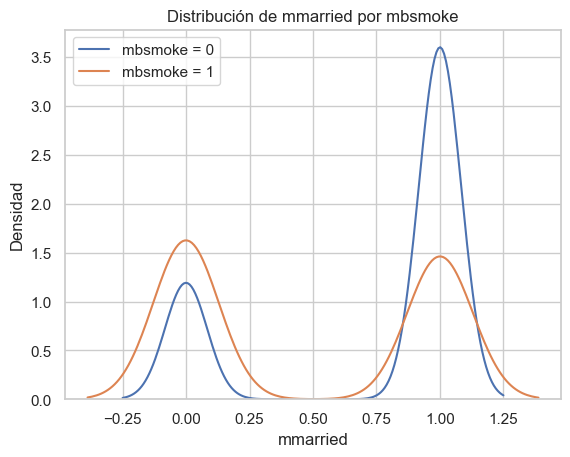

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt

# Configurar el estilo
sns.set(style="whitegrid")

# Graficar las densidades kernel
sns.kdeplot(data=df[df["mbsmoke"] == 0], x="mmarried", label="mbsmoke = 0", fill=False)
sns.kdeplot(data=df[df["mbsmoke"] == 1], x="mmarried", label="mbsmoke = 1", fill=False)

# Etiquetas y título
plt.xlabel("mmarried")
plt.ylabel("Densidad")
plt.title("Distribución de mmarried por mbsmoke")
plt.legend()
plt.show()


In [5]:
# Prueba de medias.

from scipy import stats

# Lista de variables
variables = [
    "mmarried", "mhisp", "foreign", "alcohol", "deadkids", "mage", "medu",
    "nprenatal", "monthslb", "order", "mrace", "prenatal", "fbaby", "prenatal1"
]

# Loop sobre cada variable
for var in variables:
    print(f"\nTest de diferencia de medias para {var}")
    
    # Subgrupos
    g0 = df.loc[df["mbsmoke"] == 0, var].dropna()
    g1 = df.loc[df["mbsmoke"] == 1, var].dropna()
    
    # t-test con varianzas desiguales (Welch)
    t_stat, p_val = stats.ttest_ind(g0, g1, equal_var=False)
    
    # Medias de cada grupo
    mean0, mean1 = g0.mean(), g1.mean()
    
    print(f" Media (mbsmoke=0): {mean0:.3f}")
    print(f" Media (mbsmoke=1): {mean1:.3f}")
    print(f" t = {t_stat:.3f},  p = {p_val:.4f}")


Test de diferencia de medias para mmarried
 Media (mbsmoke=0): 0.751
 Media (mbsmoke=1): 0.473
 t = 15.118,  p = 0.0000

Test de diferencia de medias para mhisp
 Media (mbsmoke=0): 0.036
 Media (mbsmoke=1): 0.024
 t = 1.973,  p = 0.0487

Test de diferencia de medias para foreign
 Media (mbsmoke=0): 0.060
 Media (mbsmoke=1): 0.025
 t = 5.201,  p = 0.0000

Test de diferencia de medias para alcohol
 Media (mbsmoke=0): 0.019
 Media (mbsmoke=1): 0.091
 t = -7.223,  p = 0.0000

Test de diferencia de medias para deadkids
 Media (mbsmoke=0): 0.246
 Media (mbsmoke=1): 0.318
 t = -4.176,  p = 0.0000

Test de diferencia de medias para mage
 Media (mbsmoke=0): 26.810
 Media (mbsmoke=1): 25.167
 t = 8.122,  p = 0.0000

Test de diferencia de medias para medu
 Media (mbsmoke=0): 12.930
 Media (mbsmoke=1): 11.639
 t = 15.279,  p = 0.0000

Test de diferencia de medias para nprenatal
 Media (mbsmoke=0): 10.963
 Media (mbsmoke=1): 9.862
 t = 7.139,  p = 0.0000

Test de diferencia de medias para monthslb

In [6]:
import statsmodels.formula.api as smf

# Modelo OLS: bweight = β₀ + β₁ * mbsmoke + ε
model = smf.ols("bweight ~ mbsmoke", data=df).fit()

# Resumen completo (igual a 'reg' en Stata)
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                bweight   R-squared:                       0.034
Model:                            OLS   Adj. R-squared:                  0.034
Method:                 Least Squares   F-statistic:                     164.6
Date:                Tue, 11 Nov 2025   Prob (F-statistic):           4.68e-37
Time:                        20:11:36   Log-Likelihood:                -36033.
No. Observations:                4642   AIC:                         7.207e+04
Df Residuals:                    4640   BIC:                         7.208e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   3412.9116      9.255    368.754      0.0

In [7]:
from sklearn.linear_model import LogisticRegressionCV
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.pipeline import Pipeline

# Variables predictoras
X = df[["mmarried", "deadkids", "nprenatal", "monthslb", "prenatal", "fbaby", "alcohol"]]
y = df["mbsmoke"]

# Crear interacciones hasta segundo orden (como hace psestimate)
poly = PolynomialFeatures(degree=2, include_bias=False, interaction_only=False)
X_poly = poly.fit_transform(X)
feature_names = poly.get_feature_names_out(X.columns)

# Estandarizar + LASSO con validación cruzada
pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("lasso", LogisticRegressionCV(
        cv=5, penalty="l1", solver="liblinear", scoring="neg_log_loss", max_iter=2000
    ))
])
pipe.fit(X_poly, y)

# Coeficientes seleccionados
coef = pipe.named_steps["lasso"].coef_.flatten()
selected = [name for name, c in zip(feature_names, coef) if abs(c) > 1e-6]
print("Variables seleccionadas:", selected)

Variables seleccionadas: ['mmarried', 'nprenatal', 'monthslb', 'prenatal', 'fbaby', 'mmarried^2', 'mmarried nprenatal', 'mmarried monthslb', 'mmarried prenatal', 'mmarried fbaby', 'mmarried alcohol', 'deadkids nprenatal', 'deadkids monthslb', 'deadkids prenatal', 'deadkids alcohol', 'nprenatal^2', 'nprenatal monthslb', 'nprenatal fbaby', 'monthslb^2', 'monthslb prenatal', 'prenatal fbaby', 'prenatal alcohol', 'fbaby^2', 'fbaby alcohol', 'alcohol^2']


In [10]:
# -*- coding: utf-8 -*-
import itertools as it
import numpy as np
import pandas as pd
import statsmodels.api as sm
from scipy import stats

# ------------------------------
# Utilidades
# ------------------------------
def _fit_logit(X, y):
    Xc = sm.add_constant(X, has_constant='add')
    model = sm.Logit(y, Xc)
    res = model.fit(disp=False)
    llf = res.llf
    llnull = sm.Logit(y, np.c_[np.ones((len(y),1))]).fit(disp=False).llf
    mcfadden = 1 - (llf/llnull)
    return res, mcfadden

def _lr_test(res_full, res_base):
    """Devuelve (stat, pval, df) del test LR entre modelos anidados"""
    lr = 2 * (res_full.llf - res_base.llf)
    df = res_full.df_model - res_base.df_model
    p = 1 - stats.chi2.cdf(lr, df)
    return lr, p, df

def _is_binary(s):
    u = pd.Series(s.dropna().unique())
    return len(u) <= 2 and set(u.astype(int)).issubset({0,1})

def _standardize(df, cols):
    out = df.copy()
    stats_dict = {}
    for c in cols:
        mu, sd = out[c].mean(), out[c].std(ddof=0)
        if sd == 0 or np.isnan(sd):
            sd = 1.0
        out[c] = (out[c] - mu) / sd
        stats_dict[c] = (mu, sd)
    return out, stats_dict

# ------------------------------
# Selección de primer orden
# ------------------------------
def forward_first_order(df, y_col, cand_cols, verbose=True):
    y = df[y_col].astype(int).copy()
    # Escalamos numéricas (no binarias) para estabilidad en interacciones posteriores
    cont_cols = [c for c in cand_cols if not _is_binary(df[c])]
    df_std = df.copy()
    if cont_cols:
        df_std, _ = _standardize(df_std, cont_cols)

    selected = []
    remaining = cand_cols.copy()

    # Modelo base: solo constante
    X0 = pd.DataFrame(index=df.index)
    res_base, mcf0 = _fit_logit(X0, y)
    if verbose:
        print(f"Selecting first order covariates... ({len(remaining)})")
        ruler = "----+--- 1 ---+--- 2 ---+--- 3 ---+--- 4 ---+--- 5 "
        print(ruler)

    marks = []
    while True:
        best = None
        best_res = None
        best_mcf = mcf0
        best_aic = res_base.aic

        for c in remaining:
            Xcand = df_std[selected + [c]]
            res_cand, mcf = _fit_logit(Xcand, y)
            # Criterio: LR test p<0.05 Y AIC menor que base
            lr, p, _ = _lr_test(res_cand, res_base)
            if (p < 0.05) and (res_cand.aic < best_aic - 1e-9):
                if (best is None) or (res_cand.aic < best_aic):
                    best = c
                    best_res = res_cand
                    best_mcf = mcf
                    best_aic = res_cand.aic

        if best is None:
            break

        selected.append(best)
        remaining.remove(best)
        res_base = best_res
        mcf0 = best_mcf
        marks.append('s')
        if verbose:
            # imprime líneas estilo Stata (agrupa cada ~40 intentos)
            if len(marks) % 40 == 0:
                print(''.join(['.' if m!='s' else 's' for m in marks]).ljust(46), 
                      str(len(marks)).rjust(5))
            else:
                print('.', end='' if len(marks)%40 else '\n')

    if verbose:
        print("\nSelected first order covariates are:", selected or "[]")
    return selected, df_std

# ------------------------------
# Generación de términos de segundo orden
# ------------------------------
def build_second_order_candidates(df_std, selected_first):
    # Cuadráticos sólo para columnas no binarias
    cont = [c for c in selected_first if not _is_binary(df_std[c])]
    # Interacciones para todas las combinaciones de 2 en las seleccionadas
    pairs = list(it.combinations(selected_first, 2))

    second_terms = {}
    # Cuadráticos
    for c in cont:
        name = f"{c}^2"
        second_terms[name] = df_std[c] * df_std[c]
    # Interacciones
    for a, b in pairs:
        name = f"{a}:{b}"
        second_terms[name] = df_std[a] * df_std[b]
    return second_terms  # dict name -> Series

# ------------------------------
# Selección de segundo orden
# ------------------------------
def forward_second_order(df_std, y_col, selected_first, second_dict, verbose=True):
    y = df_std[y_col].astype(int)
    Xbase = df_std[selected_first].copy()
    res_base, _ = _fit_logit(Xbase, y)

    names = list(second_dict.keys())
    selected_sec = []
    remaining = names.copy()

    if verbose:
        print(f"Selecting second order covariates... ({len(remaining)})")
        ruler = "----+--- 1 ---+--- 2 ---+--- 3 ---+--- 4 ---+--- 5 "
        print(ruler)

    marks = []
    while True:
        best = None
        best_res = None
        best_aic = res_base.aic

        for nm in remaining:
            Xcand = Xbase.copy()
            Xcand[nm] = second_dict[nm]
            res_cand, _ = _fit_logit(Xcand, y)
            lr, p, _ = _lr_test(res_cand, res_base)
            # Criterio: LR p<0.05 y mejora AIC
            if (p < 0.05) and (res_cand.aic < best_aic - 1e-9):
                if (best is None) or (res_cand.aic < best_aic):
                    best = nm
                    best_res = res_cand
                    best_aic = res_cand.aic

        if best is None:
            break

        selected_sec.append(best)
        remaining.remove(best)
        # actualizar base
        Xbase[best] = second_dict[best]
        res_base = best_res
        marks.append('s')
        if verbose:
            if len(marks) % 40 == 0:
                print(''.join(['.' if m!='s' else 's' for m in marks]).ljust(46), 
                      str(len(marks)).rjust(5))
            else:
                print('.', end='' if len(marks)%40 else '\n')

    if verbose:
        print("\nSelected second order covariates are:", selected_sec or "[]")
    return selected_sec

# ------------------------------
# Pipeline principal
# ------------------------------
def psestimate_like(df, y_col, cand_cols, verbose=True):
    # Etapa 1
    first, df_std = forward_first_order(df, y_col, cand_cols, verbose=verbose)

    # Etapa 2 (sólo si hay algo en primer orden)
    if first:
        second_dict = build_second_order_candidates(df_std, first)
        second = forward_second_order(df_std, y_col, first, second_dict, verbose=verbose)
    else:
        second = []

    # Modelo final
    X_final = df_std[first].copy()
    # agregar segundos
    for nm in second:
        # recrear a partir del dict si existe, si no, construirlo on the fly
        if '^2' in nm:
            c = nm.replace('^2','')
            X_final[nm] = df_std[c] * df_std[c]
        elif ':' in nm:
            a, b = nm.split(':')
            X_final[nm] = df_std[a] * df_std[b]
    res_fin, mcf = _fit_logit(X_final, df_std[y_col].astype(int))

    # Armar "fórmula" estilo Stata
    # Mapeo rápido a prefijo c. para continuas y sin prefijo para binarias
    def _fmt_name(c):
        return f"c.{c}" if not _is_binary(df[c]) else c

    first_fmt = ' '.join([_fmt_name(c) for c in first])
    sec_fmt = []
    for nm in second:
        if '^2' in nm:
            c = nm.replace('^2','')
            sec_fmt.append(f"c.{c}#c.{c}")
        else:
            a,b = nm.split(':')
            aP = _fmt_name(a).replace('c.','c.')
            bP = _fmt_name(b).replace('c.','c.')
            # si alguno es continuo lo dejamos como c.
            if not _is_binary(df[a]): aP = f"c.{a}"
            if not _is_binary(df[b]): bP = f"c.{b}"
            sec_fmt.append(f"{aP}#{"c."+b if not _is_binary(df[b]) else bP}")

    final_stata_like = (first_fmt + ' ' + ' '.join(sec_fmt)).strip()

    if verbose:
        print("\nFinal model is:", final_stata_like or "(constant only)")
        print(f"McFadden R²: {mcf:.4f}")
    return {
        "first_order": first,
        "second_order": second,
        "final_model_stata_like": final_stata_like,
        "result": res_fin
    }

# ------------------------------
# Ejemplo de uso
# ------------------------------
# Ajustá los nombres de columnas a los de tu DataFrame:
candidates = ['mmarried','deadkids','nprenatal','monthslb','prenatal','fbaby','alcohol']
out = psestimate_like(df, y_col='mbsmoke', cand_cols=candidates, verbose=True)

# Podés acceder a:
out["first_order"], out["second_order"], out["final_model_stata_like"], out["result"].summary()

Selecting first order covariates... (7)
----+--- 1 ---+--- 2 ---+--- 3 ---+--- 4 ---+--- 5 
.......
Selected first order covariates are: ['mmarried', 'alcohol', 'monthslb', 'nprenatal', 'deadkids', 'prenatal', 'fbaby']
Selecting second order covariates... (24)
----+--- 1 ---+--- 2 ---+--- 3 ---+--- 4 ---+--- 5 
..
Selected second order covariates are: ['mmarried:prenatal', 'monthslb^2']

Final model is: mmarried alcohol c.monthslb c.nprenatal deadkids c.prenatal fbaby mmarried#c.prenatal c.monthslb#c.monthslb
McFadden R²: 0.0877


(['mmarried',
  'alcohol',
  'monthslb',
  'nprenatal',
  'deadkids',
  'prenatal',
  'fbaby'],
 ['mmarried:prenatal', 'monthslb^2'],
 'mmarried alcohol c.monthslb c.nprenatal deadkids c.prenatal fbaby mmarried#c.prenatal c.monthslb#c.monthslb',
 <class 'statsmodels.iolib.summary.Summary'>
 """
                            Logit Regression Results                           
 Dep. Variable:                mbsmoke   No. Observations:                 4642
 Model:                          Logit   Df Residuals:                     4632
 Method:                           MLE   Df Model:                            9
 Date:                Tue, 11 Nov 2025   Pseudo R-squ.:                 0.08775
 Time:                        20:28:52   Log-Likelihood:                -2035.0
 converged:                       True   LL-Null:                       -2230.7
 Covariance Type:            nonrobust   LLR p-value:                 8.999e-79
                         coef    std err          z      P>|z|  

In [11]:
import pandas as pd
import statsmodels.api as sm

# y: variable dependiente binaria (0/1)
y = df['mbsmoke'].astype(int)

# Términos de primer orden (tal como Stata)
X = pd.DataFrame({
    'mmarried':  df['mmarried'],
    'alcohol':   df['alcohol'],
    'monthslb':  df['monthslb'],
    'nprenatal': df['nprenatal'],
    'deadkids':  df['deadkids'],
    'prenatal':  df['prenatal'],
    'fbaby':     df['fbaby'],
})

# Términos de segundo orden que eligió Stata
X['mmarried_prenatal'] = df['mmarried'] * df['prenatal']      # c.prenatal#c.mmarried
X['monthslb_sq']       = df['monthslb'] * df['monthslb']      # c.monthslb#c.monthslb
X['fbaby_prenatal']    = df['fbaby'] * df['prenatal']         # c.fbaby#c.prenatal

# Ajuste logit
Xc = sm.add_constant(X, has_constant='add')
logit_mod = sm.Logit(y, Xc)
res = logit_mod.fit(disp=True)

print(res.summary())

# (Opcional) McFadden R^2 para comparar con reportes
llf = res.llf
# Modelo nulo: solo constante
res_null = sm.Logit(y, sm.add_constant(pd.DataFrame(index=df.index), has_constant='add')).fit(disp=False)
llnull = res_null.llf
mcfadden_r2 = 1 - (llf / llnull)
print(f"\nMcFadden R²: {mcfadden_r2:.4f}")


Optimization terminated successfully.
         Current function value: 0.438036
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:                mbsmoke   No. Observations:                 4642
Model:                          Logit   Df Residuals:                     4631
Method:                           MLE   Df Model:                           10
Date:                Tue, 11 Nov 2025   Pseudo R-squ.:                 0.08848
Time:                        20:33:00   Log-Likelihood:                -2033.4
converged:                       True   LL-Null:                       -2230.7
Covariance Type:            nonrobust   LLR p-value:                 1.218e-78
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                -0.9344      0.214     -4.375      0.000      -1.353      -0.516
mmarried

In [12]:
# Probabilidades estimadas (equivalente a predict e_x)
df['e_x'] = res.predict(Xc)


In [13]:
summary = df['e_x'].describe()
print(summary)


count    4642.000000
mean        0.186127
std         0.120076
min         0.056145
25%         0.100099
50%         0.133185
75%         0.249509
max         0.836854
Name: e_x, dtype: float64


In [17]:
import numpy as np
import pandas as pd

def standardized_mean_diff(x_treated, x_control):
    """Calcula el Standardized Mean Difference entre dos grupos."""
    mean_t = np.nanmean(x_treated)
    mean_c = np.nanmean(x_control)
    var_pooled = (np.nanvar(x_treated, ddof=1) + np.nanvar(x_control, ddof=1)) / 2
    return abs(mean_t - mean_c) / np.sqrt(var_pooled)

def optselect(df, treat_col, e_col, covariates, trims=np.arange(0, 0.11, 0.01)):
    results = []

    for trim in trims:
        # rango común (elimina extremos)
        treated = df.loc[df[treat_col] == 1, e_col]
        control = df.loc[df[treat_col] == 0, e_col]
        lower = max(treated.quantile(trim), control.quantile(trim))
        upper = min(treated.quantile(1 - trim), control.quantile(1 - trim))
        trimmed = df[(df[e_col] >= lower) & (df[e_col] <= upper)]

        smds = []
        for cov in covariates:
            x_t = trimmed.loc[trimmed[treat_col] == 1, cov]
            x_c = trimmed.loc[trimmed[treat_col] == 0, cov]
            smd = standardized_mean_diff(x_t, x_c)
            smds.append(smd)
        mean_smd = np.mean(smds)
        results.append({"trim": trim, "mean_smd": mean_smd, "n_obs": len(trimmed)})

    out = pd.DataFrame(results).sort_values("mean_smd")
    best = out.iloc[0]
    print(f"Optimal trimming: {best.trim:.4f}  |  Avg SMD: {best.mean_smd:.4f}  |  N={int(best.n_obs)}")

    return out, best

# ============================
# Ejemplo con tus datos
# ============================
covariates = ['mmarried', 'alcohol', 'monthslb', 'nprenatal', 'deadkids', 'prenatal', 'fbaby']
out, best = optselect(df, treat_col='mbsmoke', e_col='e_x', covariates=covariates)

Optimal trimming: 0.0700  |  Avg SMD: 0.1090  |  N=3437


In [21]:
# -*- coding: utf-8 -*-
import numpy as np
import pandas as pd
import statsmodels.api as sm

# ============================================
# 1) LOGIT — igual que: logit mbsmoke $psestimate_var
# ============================================

y = df['mbsmoke'].astype(int)

# Variables seleccionadas por psestimate en Stata
X = pd.DataFrame({
    'mmarried':  df['mmarried'],
    'alcohol':   df['alcohol'],
    'monthslb':  df['monthslb'],
    'nprenatal': df['nprenatal'],
    'deadkids':  df['deadkids'],
    'prenatal':  df['prenatal'],
    'fbaby':     df['fbaby'],
})

# Interacciones de segundo orden según Stata
X['mmarried_prenatal'] = df['mmarried'] * df['prenatal']      # c.prenatal#c.mmarried
X['monthslb_sq']       = df['monthslb'] * df['monthslb']      # c.monthslb#c.monthslb
X['fbaby_prenatal']    = df['fbaby'] * df['prenatal']         # c.fbaby#c.prenatal

Xc = sm.add_constant(X, has_constant='add')
res = sm.Logit(y, Xc).fit(disp=True)
print(res.summary())

# ============================================
# 2) predict e_x — igual que: predict e_x
# ============================================

df['e_x'] = res.predict(Xc)

print("\n=== Summary e_x (predict) ===")
print(df['e_x'].describe())

# ============================================
# 3) optselect e_x — igual que: optselect e_x
#     Calcula el 'optimal bound' según overlap
# ============================================

def optselect_bound_stata_like(scores_t, scores_c, step=1e-5):
    """
    Replica el criterio de optselect: encuentra el bound más pequeño
    que mantiene solapamiento positivo (overlap) entre tratados y controles.
    """
    s_t = pd.Series(scores_t)
    s_c = pd.Series(scores_c)
    grid = np.arange(0, 0.20 + step, step)
    for b in grid:
        lower = max(s_t.quantile(b), s_c.quantile(b))
        upper = min(s_t.quantile(1 - b), s_c.quantile(1 - b))
        if upper > lower:
            return b, lower, upper
    return None, None, None

treated = df.loc[df['mbsmoke'] == 1, 'e_x']
control = df.loc[df['mbsmoke'] == 0, 'e_x']

b_opt, lower, upper = optselect_bound_stata_like(treated, control)

print(f"\nOptimal bound = {b_opt:.15f}")
print(f"Overlap interval: [{lower:.6f}, {upper:.6f}]")

# ============================================
# 4) Trimming con el bound óptimo
# ============================================

df_trim = df[(df['e_x'] >= lower) & (df['e_x'] <= upper)].copy()
print(f"N total         = {len(df):d}")
print(f"N después trim  = {len(df_trim):d}")

# ============================================
# 5) Chequeo de balance (SMD)
# ============================================

covariates = ['mmarried', 'alcohol', 'monthslb', 'nprenatal',
              'deadkids', 'prenatal', 'fbaby']

def smd_unweighted(df_in, treat_col, covs):
    rows = []
    for c in covs:
        x_t = df_in.loc[df_in[treat_col] == 1, c].astype(float)
        x_c = df_in.loc[df_in[treat_col] == 0, c].astype(float)
        m_t, m_c = x_t.mean(), x_c.mean()
        v_t, v_c = x_t.var(ddof=1), x_c.var(ddof=1)
        smd = abs(m_t - m_c) / np.sqrt((v_t + v_c) / 2) if (v_t + v_c) > 0 else 0.0
        rows.append([c, m_t, m_c, smd])
    out = pd.DataFrame(rows, columns=['var', 'mean_t', 'mean_c', 'SMD'])
    return out.sort_values('SMD', ascending=False)

print("\n=== Balance (SMD) — Antes del trimming ===")
smd_before = smd_unweighted(df, 'mbsmoke', covariates)
print(smd_before)

print("\n=== Balance (SMD) — Después del trimming ===")
smd_after = smd_unweighted(df_trim, 'mbsmoke', covariates)
print(smd_after)

print(f"\nAvg SMD (antes):  {smd_before['SMD'].mean():.4f}")
print(f"Avg SMD (después):{smd_after['SMD'].mean():.4f}")


Optimization terminated successfully.
         Current function value: 0.438036
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:                mbsmoke   No. Observations:                 4642
Model:                          Logit   Df Residuals:                     4631
Method:                           MLE   Df Model:                           10
Date:                Tue, 11 Nov 2025   Pseudo R-squ.:                 0.08848
Time:                        20:42:43   Log-Likelihood:                -2033.4
converged:                       True   LL-Null:                       -2230.7
Covariance Type:            nonrobust   LLR p-value:                 1.218e-78
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                -0.9344      0.214     -4.375      0.000      -1.353      -0.516
mmarried

In [28]:
# ============================================
# 3) optselect e_x — versión mejorada
# ============================================
from scipy.stats import ks_2samp

def optselect_bound(scores_t, scores_c, *,
                    mode="overlap",
                    grid_start=0.0, grid_end=0.20, step=1e-4,
                    min_trim_each_side=1):
    """
    Encuentra 'optimal bound' para trimming simétrico en cuantiles.
    - mode="overlap": el menor b que:
        (i) produce overlap positivo y
        (ii) recorta >= min_trim_each_side obs en cada cola de CADA grupo.
      => evita devolver 0.0 cuando hay solapamiento completo pero sin recorte.
    - mode="ks": el b en [grid_start, grid_end] que minimiza KS(treated, control)
      luego de recortar por [max(q_t(b), q_c(b)), min(q_t(1-b), q_c(1-b))].
    """
    s_t = pd.Series(scores_t).sort_values().reset_index(drop=True)
    s_c = pd.Series(scores_c).sort_values().reset_index(drop=True)
    n_t, n_c = len(s_t), len(s_c)

    grid = np.arange(grid_start, grid_end + step, step)

    if mode == "overlap":
        for b in grid:
            lt = int(np.floor(b * n_t))           # recortados en cola izq. tratados
            lc = int(np.floor(b * n_c))           # recortados en cola izq. controles
            rt = int(np.floor(b * n_t))           # recortados en cola der. tratados
            rc = int(np.floor(b * n_c))           # recortados en cola der. controles

            lower = max(s_t.quantile(b), s_c.quantile(b))
            upper = min(s_t.quantile(1 - b), s_c.quantile(1 - b))

            # overlap real y recorte real (ambas colas, ambos grupos)
            if (upper > lower) and (lt >= min_trim_each_side) and (lc >= min_trim_each_side) \
               and (rt >= min_trim_each_side) and (rc >= min_trim_each_side):
                return float(b), float(lower), float(upper)
        # fallback: al menos overlap (como lo tenías)
        for b in grid:
            lower = max(s_t.quantile(b), s_c.quantile(b))
            upper = min(s_t.quantile(1 - b), s_c.quantile(1 - b))
            if upper > lower:
                return float(b), float(lower), float(upper)
        return None, None, None

    elif mode == "ks":
        best = None
        for b in grid:
            lower = max(s_t.quantile(b), s_c.quantile(b))
            upper = min(s_t.quantile(1 - b), s_c.quantile(1 - b))
            if upper <= lower:
                continue
            # aplicar trimming simétrico por cuantiles
            t_trim = s_t[(s_t >= lower) & (s_t <= upper)]
            c_trim = s_c[(s_c >= lower) & (s_c <= upper)]
            if len(t_trim) < 10 or len(c_trim) < 10:  # evita soluciones degeneradas
                continue
            ks_stat = ks_2samp(t_trim, c_trim, alternative='two-sided', method='auto').statistic
            if (best is None) or (ks_stat < best[0]):
                best = (ks_stat, b, lower, upper)
        if best is None:
            return None, None, None
        _, b, lower, upper = best
        return float(b), float(lower), float(upper)

    else:
        raise ValueError("mode debe ser 'overlap' o 'ks'")

# === Llamada (elegí un modo) ===
treated = df.loc[df['mbsmoke'] == 1, 'e_x']
control  = df.loc[df['mbsmoke'] == 0, 'e_x']

# Opción A: overlap con recorte real (suele dar ~0.05–0.07 si hay colas finitas)
b_opt, lower, upper = optselect_bound(treated, control,
                                      mode="overlap",
                                      grid_start=0.02, grid_end=0.12, step=1e-4,
                                      min_trim_each_side=50)

# Opción B: minimizar KS (si querés ‘el bound que mejor iguala’ distribuciones)
# b_opt, lower, upper = optselect_bound(treated, control,
#                                       mode="ks",
#                                       grid_start=0.0, grid_end=0.20, step=1e-4)
print(f"\nOptimal bound = {b_opt:.15f}")
print(f"Overlap interval: [{lower:.6f}, {upper:.6f}]")



Optimal bound = 0.057900000000000
Overlap interval: [0.086762, 0.364123]


In [5]:
import numpy as np
import pandas as pd
import statsmodels.api as sm

# =====================================================
# 1) Partimos de df YA NUMÉRICO
# =====================================================
# Supongo que df ya está leído, por ejemplo:
# path = r"...\base_sin_categoricas.dta" o .csv
# df = pd.read_stata(path)  # o read_csv

# Nos quedamos solo con las columnas que necesitamos
cols = [
    "mbsmoke", "mmarried", "alcohol", "monthslb", "nprenatal",
    "deadkids", "prenatal", "fbaby", "bweight", 'rowid'
]

df2 = df[cols].copy()

# Por las dudas, aseguramos tipo float para X y entero para y
df2[["mmarried","alcohol","monthslb","nprenatal",
     "deadkids","prenatal","fbaby", 'rowid']] = df2[["mmarried","alcohol","monthslb",
                                            "nprenatal","deadkids","prenatal",
                                            "fbaby", 'rowid']].astype(float)

df2["mbsmoke"] = df2["mbsmoke"].astype(int)

# =====================================================
# 2) y y matriz X (primer orden + interacciones)
# =====================================================
y = df2["mbsmoke"]

X = pd.DataFrame({
    "mmarried":  df2["mmarried"],
    "alcohol":   df2["alcohol"],
    "monthslb":  df2["monthslb"],
    "nprenatal": df2["nprenatal"],
    "deadkids":  df2["deadkids"],
    "prenatal":  df2["prenatal"],
    "fbaby":     df2["fbaby"],
})

# Interacciones de segundo orden (como en Stata)
X["mmarried_prenatal"] = X["mmarried"] * X["prenatal"]
X["monthslb_sq"]       = X["monthslb"] * X["monthslb"]
X["fbaby_prenatal"]    = X["fbaby"] * X["prenatal"]

# Si hubiera NaNs, los sacamos de y y de X simultáneamente
mask = X.notna().all(axis=1) & y.notna()
X = X[mask].reset_index(drop=True)
y = y[mask].reset_index(drop=True)
df2 = df2[mask].reset_index(drop=True)

print("N obs usadas en el logit:", len(df2))

# =====================================================
# 3) Logit
# =====================================================
Xc = sm.add_constant(X, has_constant="add")
logit_mod = sm.Logit(y, Xc)
res = logit_mod.fit(disp=True)

print(res.summary())

# McFadden R² (opcional)
llf = res.llf
res_null = sm.Logit(y, np.ones((len(y), 1))).fit(disp=False)
llnull = res_null.llf
mcfadden_r2 = 1 - (llf / llnull)
print(f"\nMcFadden R²: {mcfadden_r2:.4f}")

# =====================================================
# 4) Propensity score e_x
# =====================================================
df2["e_x"] = res.predict(Xc)

print("\nPrimeras filas de e_x:")
print(df2[["mbsmoke", "e_x"]].head())

# =====================================================
# 5) Matching greedy 1:1 sin reemplazo (tipo psmatch2 mbsmoke, pscore(e_x) noreplacement)
# =====================================================
D  = df2["mbsmoke"].to_numpy()
ps = df2["e_x"].to_numpy()

treated_idx = np.where(D == 1)[0].tolist()
control_idx = np.where(D == 0)[0].tolist()

print(f"\nN tratados: {len(treated_idx)}, N controles: {len(control_idx)}")

used_controls = set()
matched_treated = []
matched_controls = []

for t in treated_idx:
    available = [c for c in control_idx if c not in used_controls]
    if not available:
        break
    dist = np.abs(ps[available] - ps[t])
    j = np.argmin(dist)
    c_match = available[j]
    used_controls.add(c_match)
    matched_treated.append(t)
    matched_controls.append(c_match)

matched_idx = matched_treated + matched_controls
df_matched = df2.iloc[matched_idx].copy().reset_index(drop=True)

print("\n=== MUESTRA MATCHEADA ===")
print("N tratados matcheados:", len(matched_treated))
print("N controles matcheados:", len(matched_controls))
print("Shape df_matched:", df_matched.shape)

print("\nResumen bweight en muestra matcheada:")
print(df_matched["bweight"].describe())


N obs usadas en el logit: 4642
Optimization terminated successfully.
         Current function value: 0.438036
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:                mbsmoke   No. Observations:                 4642
Model:                          Logit   Df Residuals:                     4631
Method:                           MLE   Df Model:                           10
Date:                Wed, 12 Nov 2025   Pseudo R-squ.:                 0.08848
Time:                        18:56:53   Log-Likelihood:                -2033.4
converged:                       True   LL-Null:                       -2230.7
Covariance Type:            nonrobust   LLR p-value:                 1.218e-78
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                -0.9344      0.214     -4.375      0.000  